# Topic Modeling

In [ ]:
import pandas as pd

df = pd.read_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv")
df.head()

abstract update_date  \
0    A fully differential calculation in perturba...  2008-11-26   
1    We describe a new algorithm, the $(k,\ell)$-...  2008-12-13   
2    The evolution of Earth-Moon system is descri...  2008-01-13   
3    We show that a determinant of Stirling cycle...  2007-05-23   
4    In this paper we show how to compute the $\L...  2013-10-15   

                                  processed_abstract      merged_category  
0  fully differential calculation perturbative qu...  High Energy Physics  
1  describe new algorithm game color use obtain c...          Mathematics  
2  evolution system described dark matter field f...              Physics  
3  show determinant stirling cycle number count u...          Mathematics  
4  paper show compute norm 0 using dyadic grid re...          Mathematics

# LDA (Latent Dirichlet Allocation)

Creating document-term matrix...
Document-term matrix shape: (10000, 10000)
Evaluating model with 5 topics...
Evaluating model with 10 topics...
Evaluating model with 15 topics...
Evaluating model with 20 topics...
Evaluating model with 25 topics...


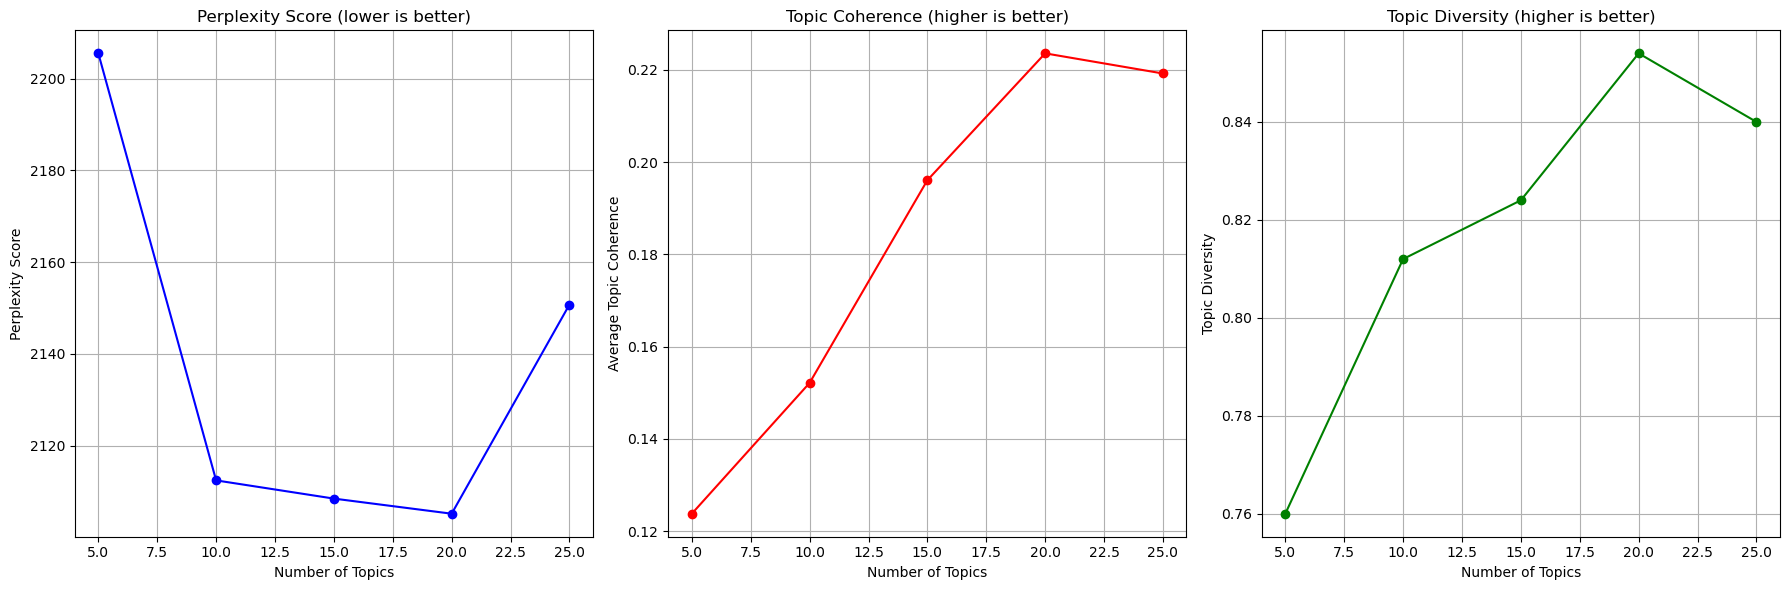

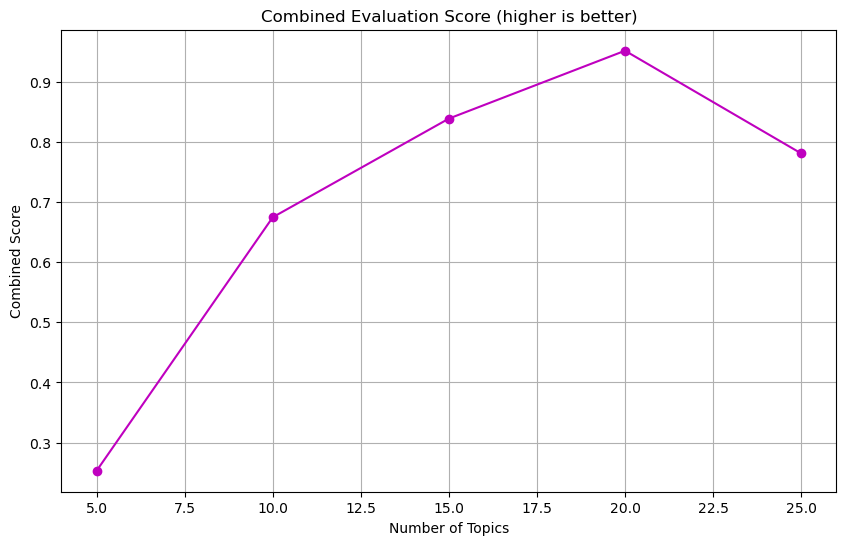


Optimal number of topics based on combined metrics: 20
Training final LDA model with 20 topics...

Top 10 words per topic:
Topic 0: symmetry model lattice mass vortex higgs boson chiral fermion phase
Topic 1: investor synergy food regulator cot income household regularisation dsa 2022
Topic 2: group algebra ring subgroup module logic cohomology finite abelian cyclic
Topic 3: theory field hole quantum black scalar gauge solution gravity string
Topic 4: fingerprint soc occupancy ip apps authentication earthquake synchronized locking android
Topic 5: space result function paper prove set operator class graph equation
Topic 6: jet network event node market risk pattern activity price financial
Topic 7: energy model mass decay data matter effect result dark parameter
Topic 8: damping car wc snake comb adjustable pid epsilon muchnik muscle
Topic 9: star galaxy mass observation cluster emission source observed data spectrum
Topic 10: surface phase cell layer molecule flux film interface liqu

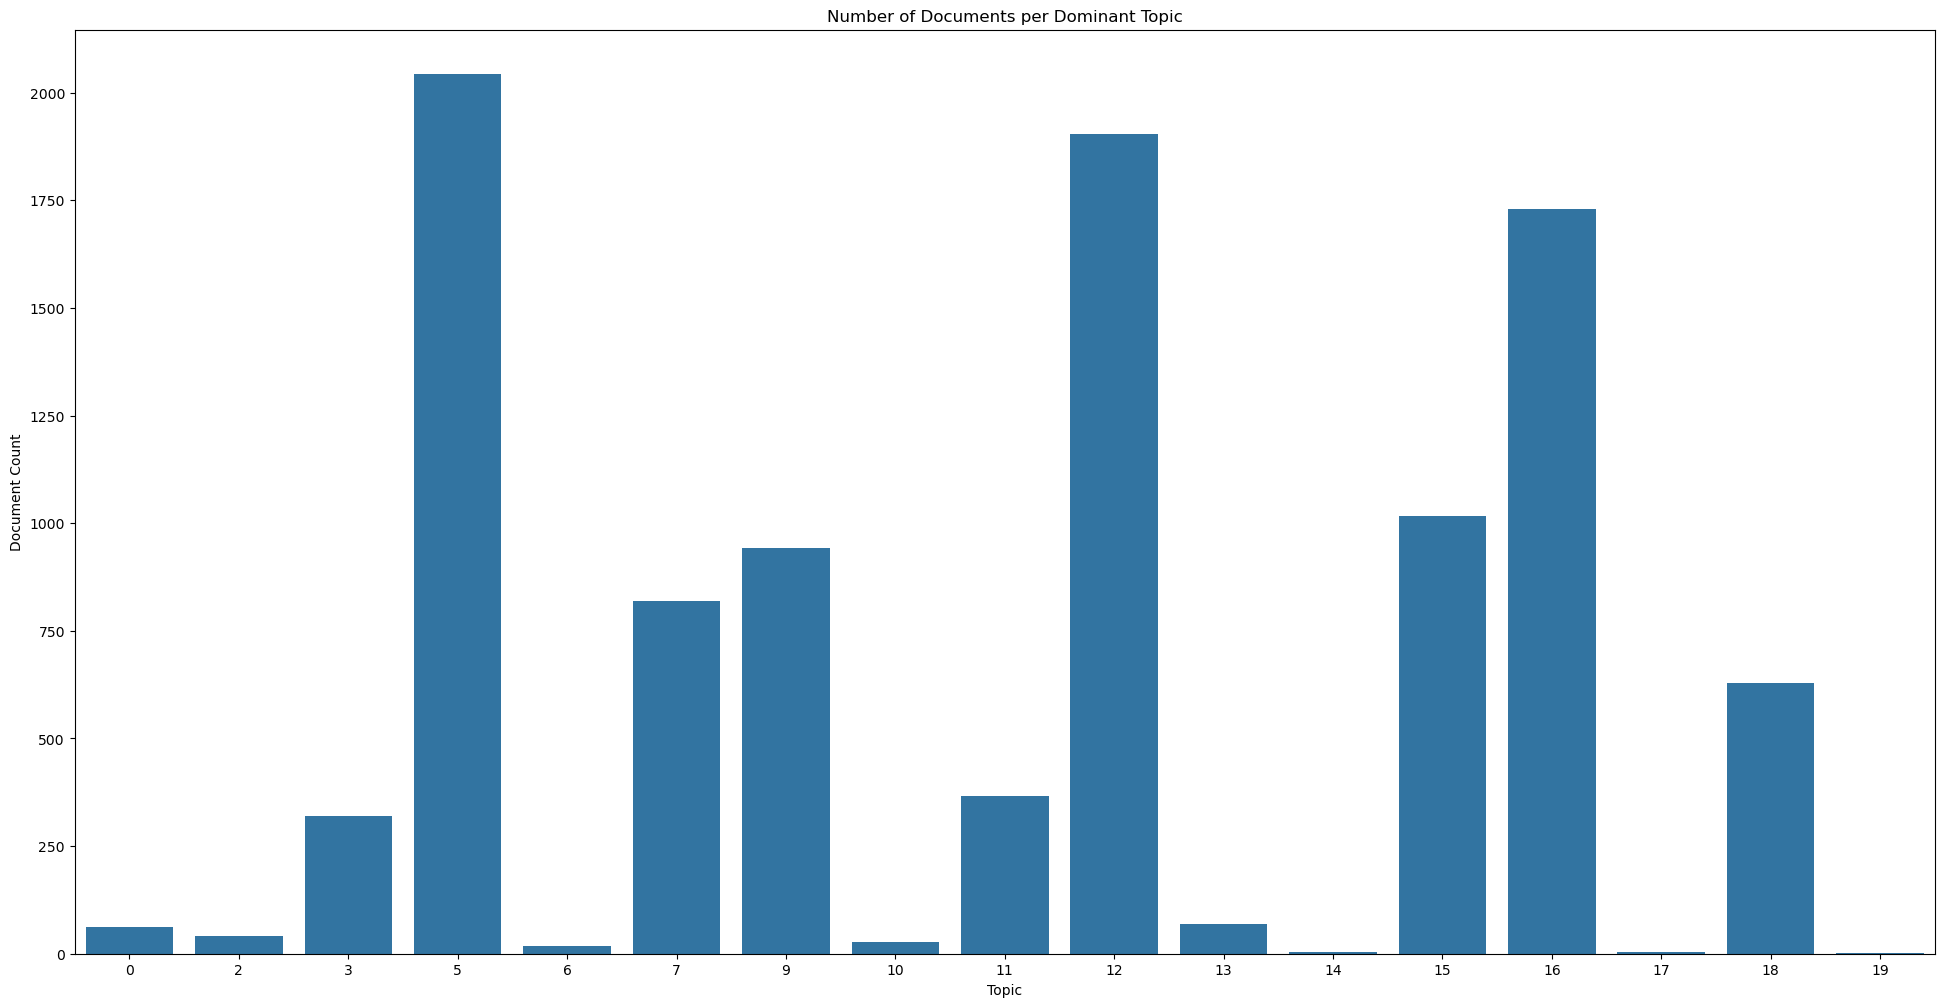

<Figure size 2000x1200 with 0 Axes>

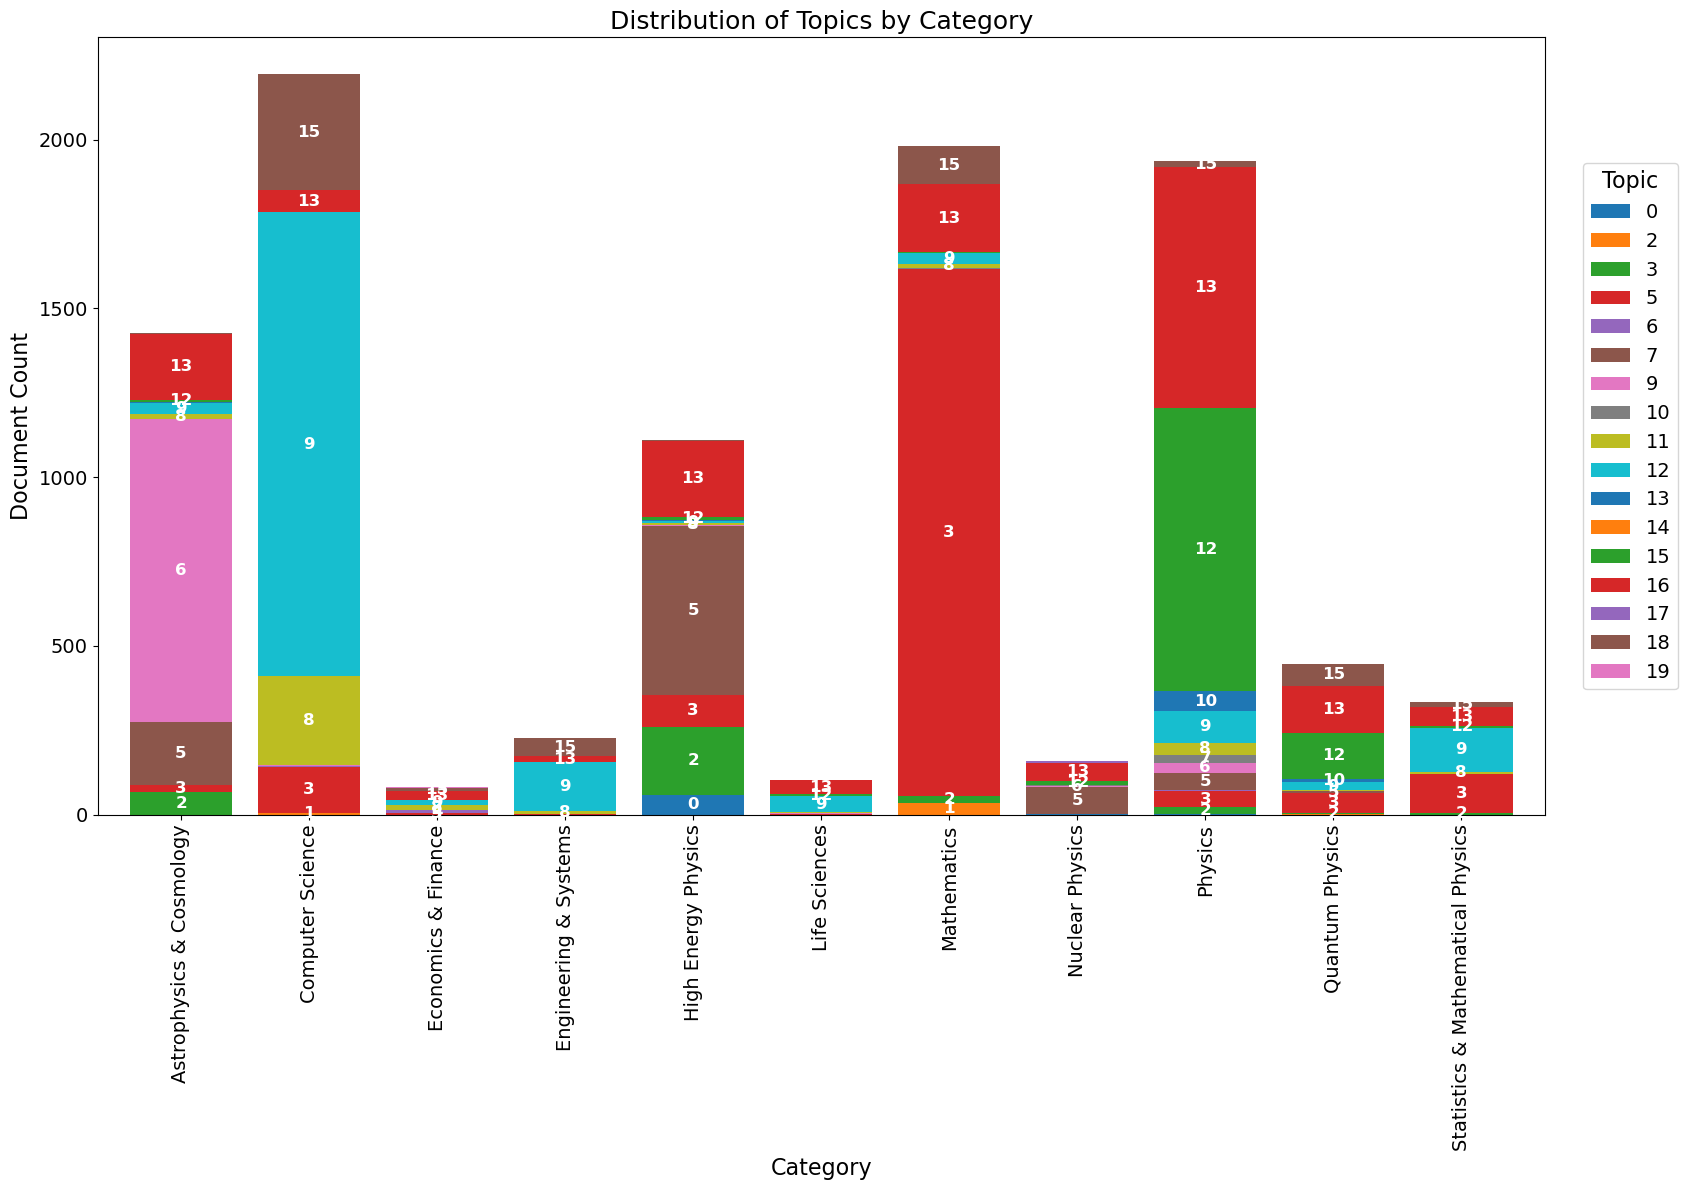

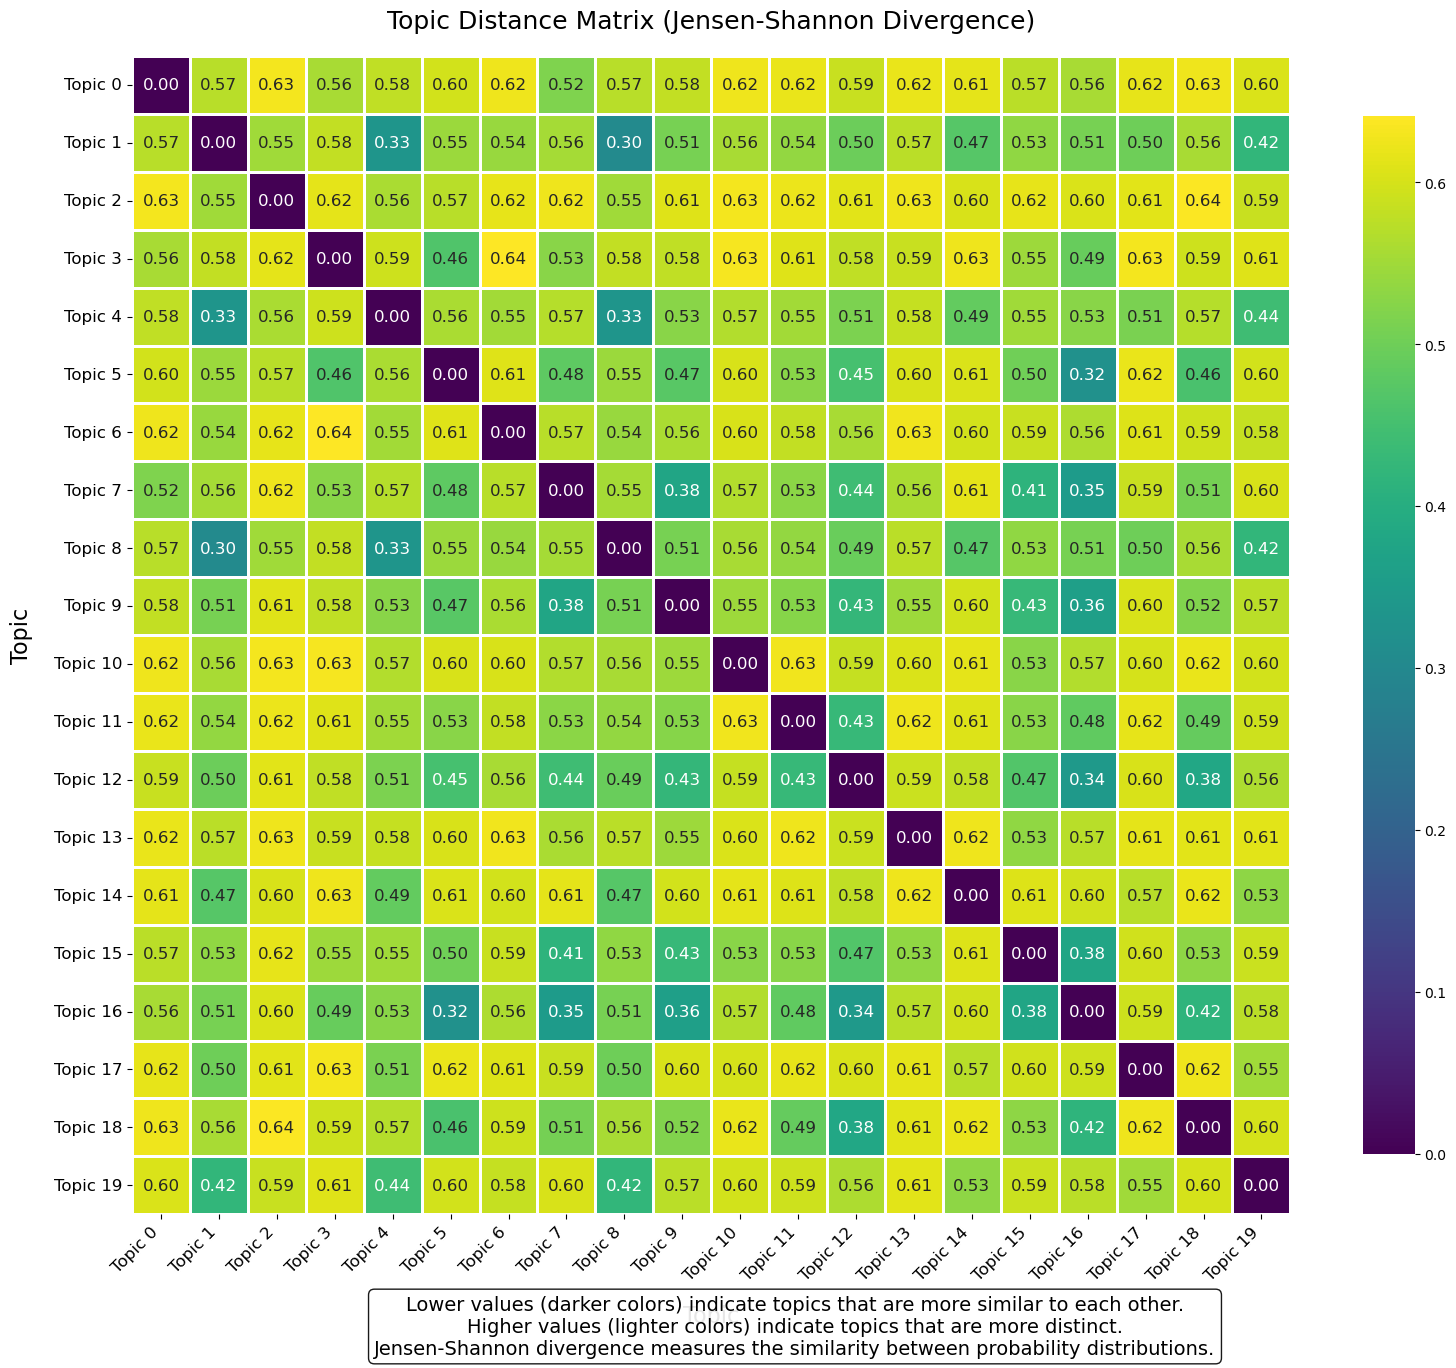


Evaluation Results:
   n_topics   perplexity  avg_coherence  topic_diversity  combined_score
0         5  2205.522835       0.123777            0.760        0.253333
1        10  2112.446440       0.152133            0.812        0.674584
2        15  2108.476239       0.196079            0.824        0.838552
3        20  2105.184366       0.223578            0.854        0.951333
4        25  2150.762968       0.219210            0.840        0.780663


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# 1. Prepare text data
df = pd.read_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv").sample(n=10000, random_state=42)
df = df.dropna(subset=['processed_abstract'])
documents = df['processed_abstract'].tolist()

# 2. Create document-term matrix with CountVectorizer
print("Creating document-term matrix...")
vectorizer = CountVectorizer(
    max_df=0.95,            # Ignore terms that appear in more than 95% of documents
    min_df=2,               # Ignore terms that appear in fewer than 2 documents
    stop_words='english',
    max_features=10000       # Limit vocabulary size
)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {X.shape}")

# 3. Function to evaluate LDA models with TC and TD metrics
def evaluate_lda_models(X, feature_names, range_topics):
    results = []

    for n_topics in range_topics:
        print(f"Evaluating model with {n_topics} topics...")
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=10,
            learning_method='online',
            learning_offset=50.,
            random_state=42
        )
        lda.fit(X)

        # Calculate metrics
        perplexity = lda.perplexity(X)

        # Topic Coherence - using NPMI-inspired approach
        topic_coherence = calculate_topic_coherence(lda.components_, X, feature_names)
        avg_coherence = np.mean(topic_coherence)

        # Topic Diversity - using term-based approach
        topic_diversity = calculate_topic_diversity(lda.components_)

        results.append({
            'n_topics': n_topics,
            'perplexity': perplexity,
            'avg_coherence': avg_coherence,
            'topic_diversity': topic_diversity
        })

    return pd.DataFrame(results)

# Topic Coherence calculation function
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]

    for topic_idx, topic_dist in enumerate(topic_word_dist):

        # Get top N words for this topic
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(top_word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(top_word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_dist in topic_word_dist:
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]
        topics_top_words.append(set(top_word_indices))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topic_word_dist) * top_n)

# 4. Try a range of topic numbers
topic_range = range(5, 26, 5)  # [5, 10, 15, 20, 25]
evaluation_results = evaluate_lda_models(X, feature_names, topic_range)

# 5. Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Perplexity plot
axes[0].plot(evaluation_results['n_topics'], evaluation_results['perplexity'], 'bo-')
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Perplexity Score')
axes[0].set_title('Perplexity Score (lower is better)')
axes[0].grid(True)

# Topic coherence plot
axes[1].plot(evaluation_results['n_topics'], evaluation_results['avg_coherence'], 'ro-')
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Average Topic Coherence')
axes[1].set_title('Topic Coherence (higher is better)')
axes[1].grid(True)

# Topic diversity plot
axes[2].plot(evaluation_results['n_topics'], evaluation_results['topic_diversity'], 'go-')
axes[2].set_xlabel('Number of Topics')
axes[2].set_ylabel('Topic Diversity')
axes[2].set_title('Topic Diversity (higher is better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 6. Decide on optimal number of topics (simple approach)
# Weight each metric: lower perplexity, higher coherence, higher diversity
normalized_perplexity = 1 - (evaluation_results['perplexity'] - min(evaluation_results['perplexity'])) / (max(evaluation_results['perplexity']) - min(evaluation_results['perplexity']) + 1e-10)
normalized_coherence = (evaluation_results['avg_coherence'] - min(evaluation_results['avg_coherence'])) / (max(evaluation_results['avg_coherence']) - min(evaluation_results['avg_coherence']) + 1e-10)
normalized_diversity = evaluation_results['topic_diversity']

# Combined score (equal weights)
evaluation_results['combined_score'] = (normalized_perplexity + normalized_coherence + normalized_diversity) / 3

# Plot combined score
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['n_topics'], evaluation_results['combined_score'], 'mo-')
plt.xlabel('Number of Topics')
plt.ylabel('Combined Score')
plt.title('Combined Evaluation Score (higher is better)')
plt.grid(True)
plt.show()

# Find optimal number of topics
optimal_topics = evaluation_results.loc[evaluation_results['combined_score'].idxmax(), 'n_topics']
print(f"\nOptimal number of topics based on combined metrics: {optimal_topics}")

# 7. Train the final LDA model
print(f"Training final LDA model with {optimal_topics} topics...")

lda_model = LatentDirichletAllocation(
    n_components=optimal_topics,
    max_iter=25,
    learning_method='online',
    learning_offset=50.,
    random_state=42
)
lda_model.fit(X)

# 8. Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[topic_idx] = topic_words
        print(f"Topic {topic_idx}: {' '.join(topic_words)}")
    return topic_dict

print("\nTop 10 words per topic:")
topic_dict = display_topics(lda_model, feature_names, 10)

# 9. Calculate final TC and TD metrics for the optimal model
final_coherence = calculate_topic_coherence(lda_model.components_, X, feature_names)
final_diversity = calculate_topic_diversity(lda_model.components_)

print("\nFinal Topic Coherence scores per topic:")
for i, score in enumerate(final_coherence):
    print(f"Topic {i}: {score:.4f}")
print(f"Average Topic Coherence: {np.mean(final_coherence):.4f}")
print(f"Topic Diversity: {final_diversity:.4f}")

# 10. Visualize document distribution across topics
topic_distribution = lda_model.transform(X)
dominant_topics = np.argmax(topic_distribution, axis=1)

# Count documents per dominant topic
topic_counts = np.bincount(dominant_topics, minlength=optimal_topics)

# Create a DataFrame with document-topic distribution
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': dominant_topics,
    'category': df['merged_category']
})

# Plot document count by dominant topic
plt.figure(figsize=(24, 12))
sns.countplot(x='dominant_topic', data=topic_df)
plt.title('Number of Documents per Dominant Topic')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.show()

# 11. Analysis by category
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df['category'], topic_df['dominant_topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Position the legend outside the plot to the right
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = i
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 12. Topic distance visualization
# Calculate distance between topics using Jensen-Shannon divergence
def js_distance(P, Q):
    """Calculate Jensen-Shannon distance between probability distributions"""
    # Normalize if not already
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    M = 0.5 * (P + Q)
    return 0.5 * (np.sum(P * np.log(P / M + 1e-10)) + np.sum(Q * np.log(Q / M + 1e-10)))

# Calculate the distance matrix
topic_distances = np.zeros((optimal_topics, optimal_topics))
for i in range(optimal_topics):
    for j in range(i+1, optimal_topics):
        dist = js_distance(lda_model.components_[i], lda_model.components_[j])
        topic_distances[i, j] = dist
        topic_distances[j, i] = dist

plt.figure(figsize=(16, 14))
topic_labels = [f"Topic {i}" for i in range(optimal_topics)]

ax = sns.heatmap(
    topic_distances,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

# Improve the appearance of the plot
plt.title('Topic Distance Matrix (Jensen-Shannon Divergence)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)

# Increase the font size of tick labels
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)

# Add a text explanation in the figure
plt.figtext(
    0.5, 0.01,
    "Lower values (darker colors) indicate topics that are more similar to each other.\n"
    "Higher values (lighter colors) indicate topics that are more distinct.\n"
    "Jensen-Shannon divergence measures the similarity between probability distributions.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

# Adjust layout
plt.tight_layout()
plt.show()

print("\nEvaluation Results:")
print(evaluation_results)

# NMF (Non-negative Matrix Factorization)

Creating document-term matrix...
Document-term matrix shape: (10000, 15000)
Evaluating model with 5 topics...
Evaluating model with 10 topics...
Evaluating model with 15 topics...
Evaluating model with 20 topics...
Evaluating model with 25 topics...


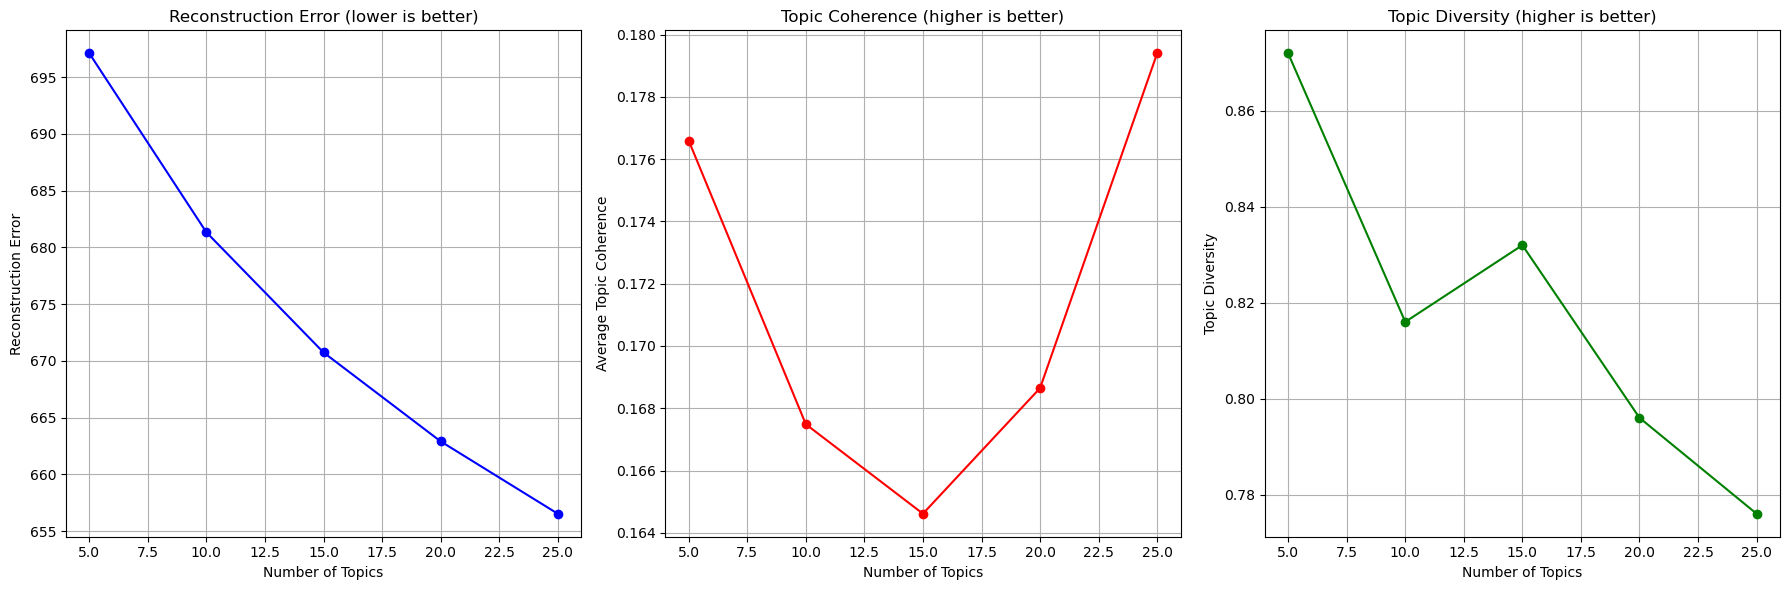

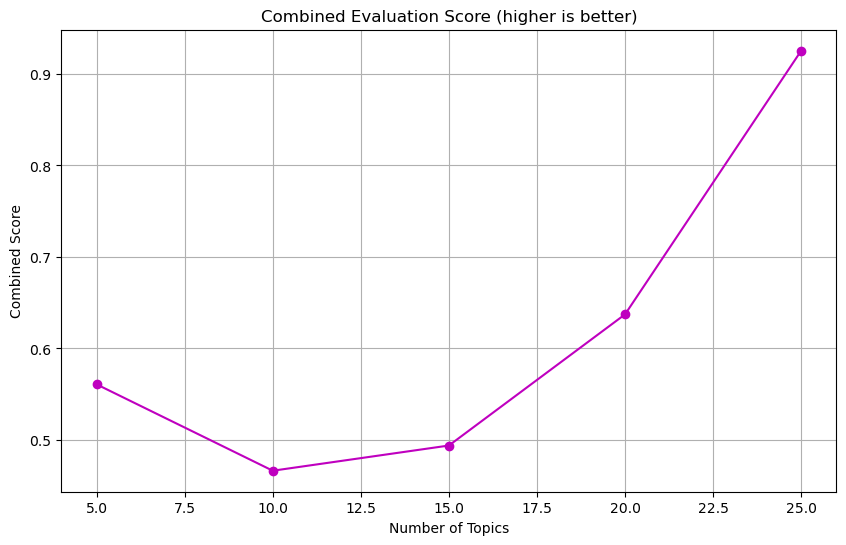


Optimal number of topics based on combined metrics: 25
Training final NMF model with 25 topics...

Top 10 words per topic:
Topic 0: model new work approach analysis important different information theoretical general
Topic 1: image learning model training task neural network method feature performance
Topic 2: prove group equation solution theorem condition result existence proof operator
Topic 3: quantum spin state circuit device electron cavity gate coupling mode
Topic 4: cluster galaxy star stellar mass formation gas disk velocity cloud
Topic 5: theory action gauge group field category representation string space dual
Topic 6: molecule energy temperature material electron atom calculation molecular structure electronic
Topic 7: decay mass neutrino quark production higgs cross meson qcd section
Topic 8: graph hole black gravity scalar solution field perturbation equation theory
Topic 9: model dynamic equation diffusion equilibrium time scaling behavior particle law
Topic 10: wave be

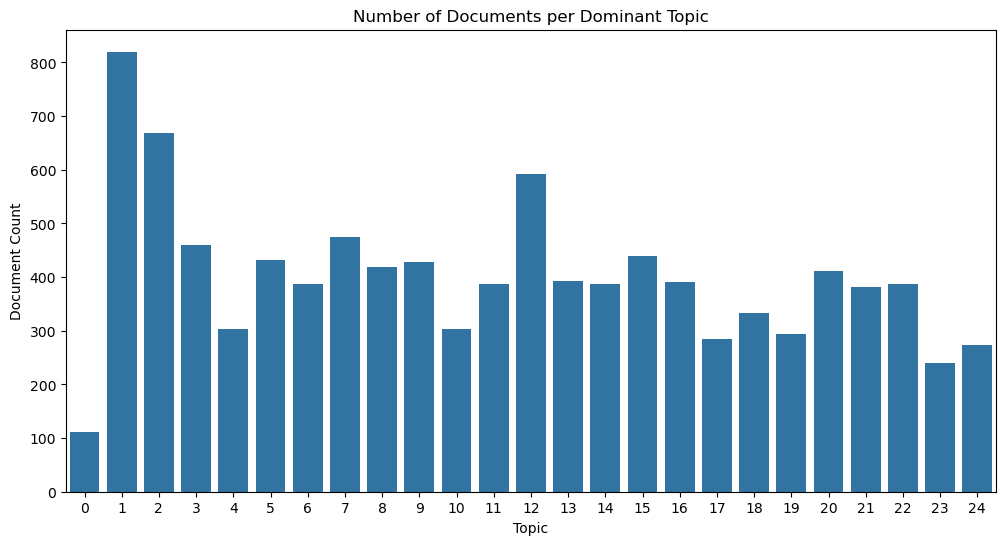

<Figure size 2000x1200 with 0 Axes>

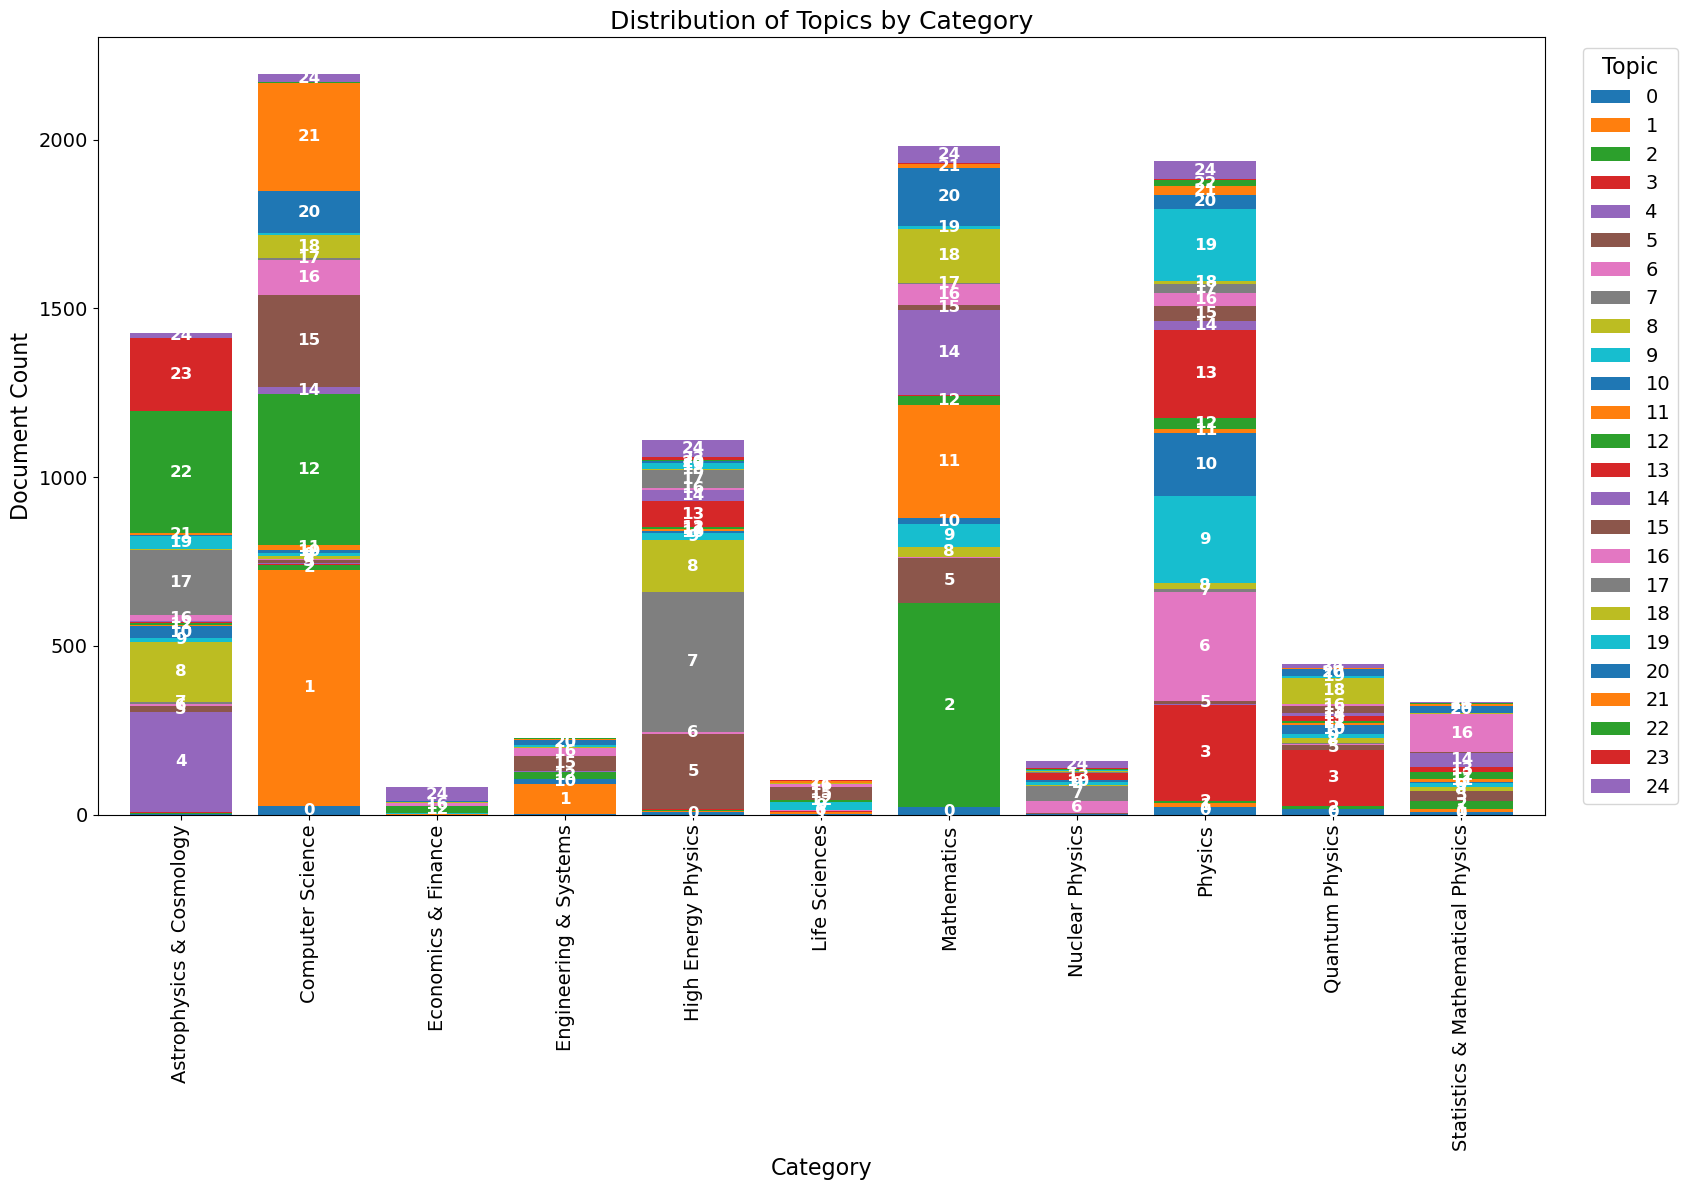

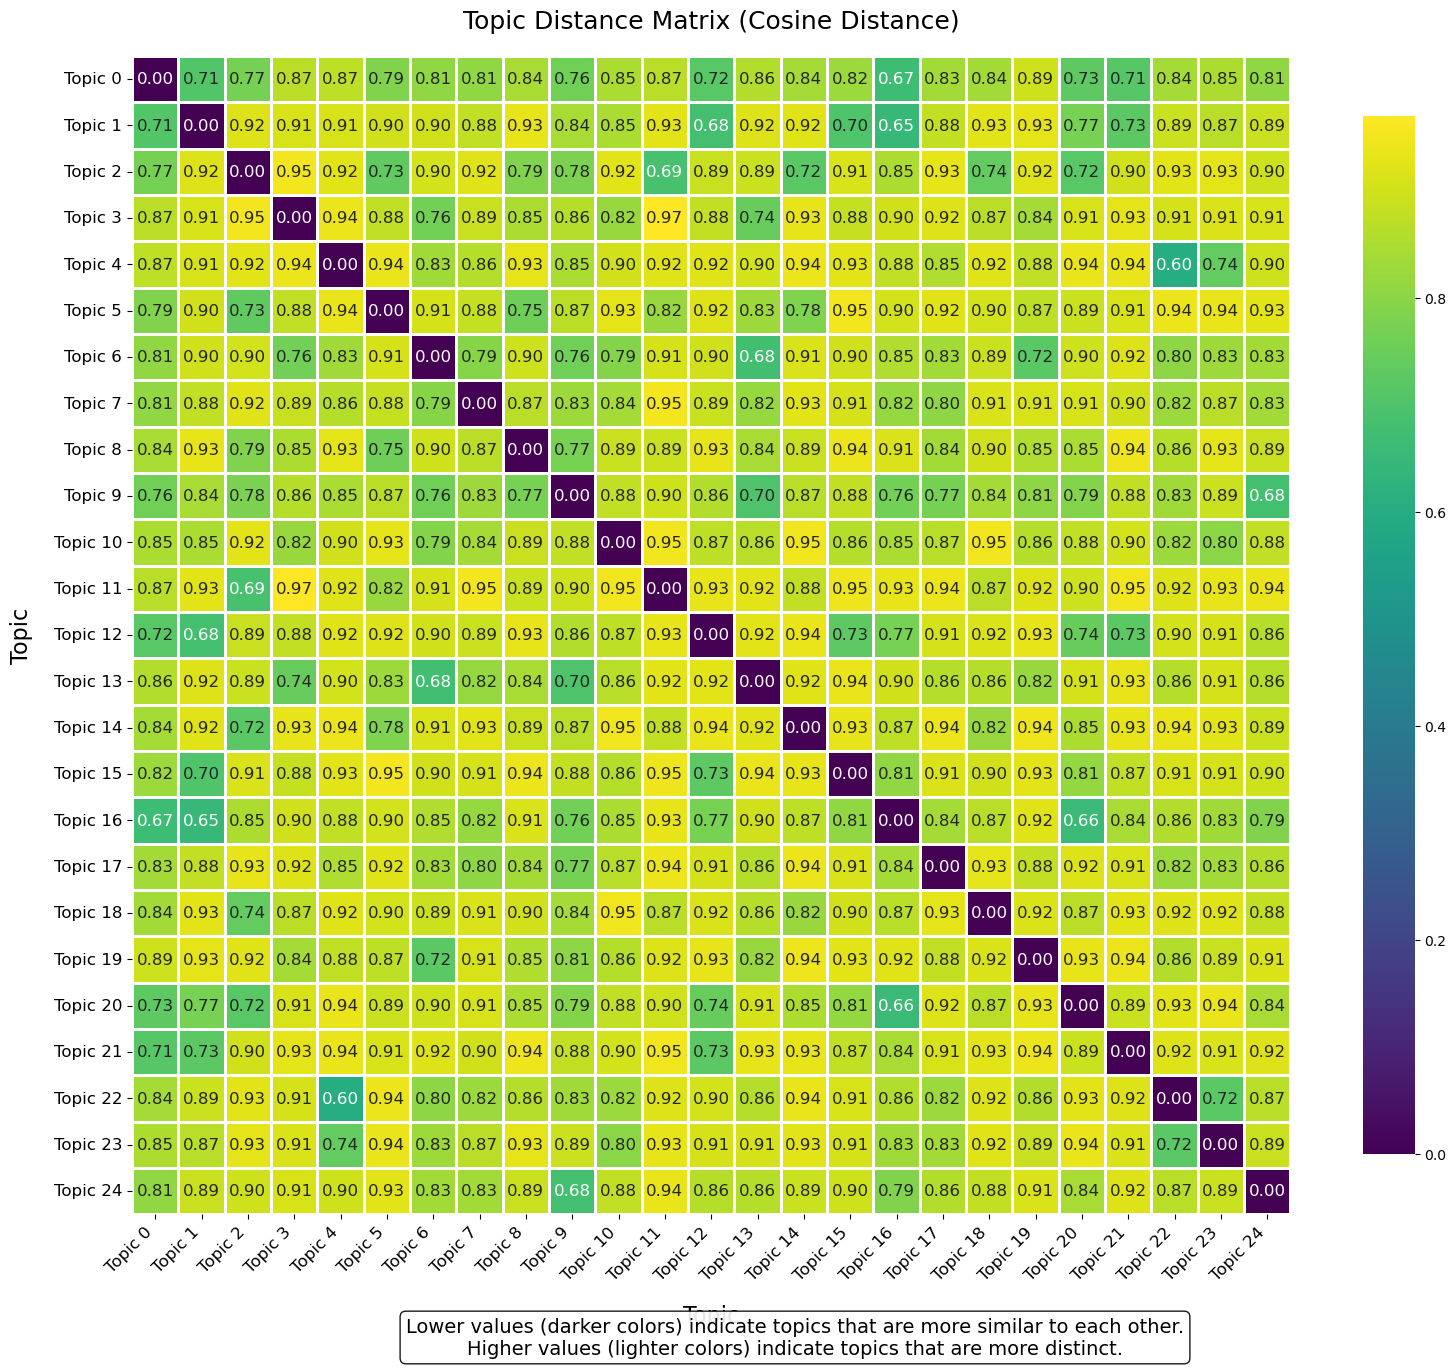


Evaluation Results:
   n_topics  reconstruction_error  avg_coherence  topic_diversity  \
0         5            697.089272       0.176590            0.872   
1        10            681.323779       0.167485            0.816   
2        15            670.744448       0.164613            0.832   
3        20            662.913328       0.168646            0.796   
4        25            656.542377       0.179396            0.776   

   combined_score  
0        0.560744  
1        0.466374  
2        0.493912  
3        0.637227  
4        0.925333  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# 1. Prepare text data
df = pd.read_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv").sample(n=10000, random_state=42)
df = df.dropna(subset=['processed_abstract'])
documents = df['processed_abstract'].tolist()

# 2. Create document-term matrix with TfidfVectorizer (common for NMF)
print("Creating document-term matrix...")
vectorizer = TfidfVectorizer(
    max_df=0.95,    # Ignore terms that appear in more than 95% of documents
    min_df=2,       # Ignore terms that appear in fewer than 2 documents
    stop_words='english',
    max_features=15000  # Limit vocabulary size
)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {X.shape}")

# 3. Topic Coherence calculation function
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]

    for topic_idx, topic_dist in enumerate(topic_word_dist):
        # Get top N words for this topic
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(top_word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(top_word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_dist in topic_word_dist:
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]
        topics_top_words.append(set(top_word_indices))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topic_word_dist) * top_n)

# 4. Function to evaluate NMF models with TC and TD metrics
def evaluate_nmf_models(X, feature_names, range_topics):
    results = []

    for n_topics in range_topics:
        print(f"Evaluating model with {n_topics} topics...")
        nmf = NMF(
            n_components=n_topics,
            random_state=42,
            beta_loss='kullback-leibler',
            solver='mu'
        )
        W = nmf.fit_transform(X)  # Document-topic matrix
        H = nmf.components_      # Topic-term matrix

        # Calculate reconstruction error
        error = nmf.reconstruction_err_

        # Topic Coherence - using NPMI-inspired approach
        topic_coherence = calculate_topic_coherence(H, X, feature_names)
        avg_coherence = np.mean(topic_coherence)

        # Topic Diversity - using term-based approach
        topic_diversity = calculate_topic_diversity(H)

        results.append({
            'n_topics': n_topics,
            'reconstruction_error': error,
            'avg_coherence': avg_coherence,
            'topic_diversity': topic_diversity
        })

    return pd.DataFrame(results)

# 5. Try a range of topic numbers
topic_range = range(5, 26, 5)  # [5, 10, 15, 20, 25]
evaluation_results = evaluate_nmf_models(X, feature_names, topic_range)

# 6. Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Reconstruction error plot
axes[0].plot(evaluation_results['n_topics'], evaluation_results['reconstruction_error'], 'bo-')
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Reconstruction Error')
axes[0].set_title('Reconstruction Error (lower is better)')
axes[0].grid(True)

# Topic coherence plot
axes[1].plot(evaluation_results['n_topics'], evaluation_results['avg_coherence'], 'ro-')
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Average Topic Coherence')
axes[1].set_title('Topic Coherence (higher is better)')
axes[1].grid(True)

# Topic diversity plot
axes[2].plot(evaluation_results['n_topics'], evaluation_results['topic_diversity'], 'go-')
axes[2].set_xlabel('Number of Topics')
axes[2].set_ylabel('Topic Diversity')
axes[2].set_title('Topic Diversity (higher is better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 7. Decide on optimal number of topics (simple approach)
# Weight each metric: lower error, higher coherence, higher diversity
normalized_error = 1 - (evaluation_results['reconstruction_error'] - min(evaluation_results['reconstruction_error'])) / (max(evaluation_results['reconstruction_error']) - min(evaluation_results['reconstruction_error']) + 1e-10)
normalized_coherence = (evaluation_results['avg_coherence'] - min(evaluation_results['avg_coherence'])) / (max(evaluation_results['avg_coherence']) - min(evaluation_results['avg_coherence']) + 1e-10)
normalized_diversity = evaluation_results['topic_diversity']

# Combined score (equal weights)
evaluation_results['combined_score'] = (normalized_error + normalized_coherence + normalized_diversity) / 3

# Plot combined score
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['n_topics'], evaluation_results['combined_score'], 'mo-')
plt.xlabel('Number of Topics')
plt.ylabel('Combined Score')
plt.title('Combined Evaluation Score (higher is better)')
plt.grid(True)
plt.show()

# Find optimal number of topics
optimal_topics = evaluation_results.loc[evaluation_results['combined_score'].idxmax(), 'n_topics']
print(f"\nOptimal number of topics based on combined metrics: {optimal_topics}")

# 8. Train the final NMF model
print(f"Training final NMF model with {optimal_topics} topics...")

nmf_model = NMF(
    n_components=optimal_topics,
    random_state=42,
    beta_loss='kullback-leibler',
    solver='mu'
)
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

# 9. Display top words for each topic
def display_topics(model_components, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model_components):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[topic_idx] = topic_words
        print(f"Topic {topic_idx}: {' '.join(topic_words)}")
    return topic_dict

print("\nTop 10 words per topic:")
topic_dict = display_topics(H, feature_names, 10)

# 10. Calculate final TC and TD metrics for the optimal model
final_coherence = calculate_topic_coherence(H, X, feature_names)
final_diversity = calculate_topic_diversity(H)

print("\nFinal Topic Coherence scores per topic:")
for i, score in enumerate(final_coherence):
    print(f"Topic {i}: {score:.4f}")
print(f"Average Topic Coherence: {np.mean(final_coherence):.4f}")
print(f"Topic Diversity: {final_diversity:.4f}")

# 11. Visualize document distribution across topics
# For NMF, we take the highest weighted topic for each document as the dominant topic
dominant_topics = np.argmax(W, axis=1)

# Count documents per dominant topic
topic_counts = np.bincount(dominant_topics, minlength=optimal_topics)

# Create a DataFrame with document-topic distribution
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': dominant_topics,
    'category': df['merged_category']
})

# Plot document count by dominant topic
plt.figure(figsize=(12, 6))
sns.countplot(x='dominant_topic', data=topic_df)
plt.title('Number of Documents per Dominant Topic')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.show()

# 12. Analysis by category with topic numbers on bars
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df['category'], topic_df['dominant_topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Position the legend outside the plot to the right
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = i
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 13. Topic distance visualization
# Calculate distance between topics using cosine distance (appropriate for NMF)
topic_distances = cosine_distances(H)
plt.figure(figsize=(16, 14))

# Custom labels for the axes that include "Topic X"
topic_labels = [f"Topic {i}" for i in range(len(topic_distances))]

ax = sns.heatmap(
    topic_distances,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

plt.title('Topic Distance Matrix (Cosine Distance)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)

plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)

# Add a text explanation in the figure
plt.figtext(
    0.5, 0.01,
    "Lower values (darker colors) indicate topics that are more similar to each other.\n"
    "Higher values (lighter colors) indicate topics that are more distinct.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.show()

# Display the evaluation table
print("\nEvaluation Results:")
print(evaluation_results)

# Top2Vec

In [ ]:
!pip install top2vec --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
from google.colab import drive
import pandas as pd

try:
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/arxiv_preprocessed.csv'
    df = pd.read_csv(file_path).sample(n=100000, random_state=42)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_FILE}")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully. Shape: (100000, 4)
                                                  abstract update_date  \
916746     Continuing the work of \cite{7} and \cite{8}...  2017-11-28   
368210     We compute the dependence of the Higgs to tw...  2013-10-31   
2483072    The heavy quark production in ultraperiphera...  2009-01-07   
1906818    This paper introduces PROMISE ($\textbf{Pr}$...  2024-03-15   
951855     Universe history in $R^2$-gravity is studied...  2018-11-27   

                                        processed_abstract  \
916746   continuing work 7 8 derive analogue classical ...   
368210   compute dependence higgs decay rate heavy top ...   
2483072  heavy quark production ultraperipheral heavy i...   
1906818  paper introduces promise econditioned stochast...   
951855   universe history studied beginning present epo...   

     

Evaluating Top2Vec models with different parameters...
Training model with min_count=20, n_neighbors=5...
  Trying min_cluster_size=200...
    Found 2 topics
  Best model has 2 topics with min_cluster_size=200
  Topic counts: {0: 67855, 1: 32144}
  Topics sorted by size: [(0, 67855), (1, 32144)]
  Selected topics: [0, 1]
  Final number of topics: 2
  Avg coherence: 0.1903
  Topic diversity: 1.0000

Best model parameters:
min_count: 20
n_neighbors: 5
min_cluster_size: 200
Original number of topics: 2
Selected number of topics: 2
Average coherence: 0.1903
Topic diversity: 1.0000

Top 10 words per topic:
Topic 0 (original #0): proof lipschitz theorem knuth malliavin regularity optimality semicontinuous convex norm
Topic 1 (original #1): electroweak mass hadronic lepton quark hadron universe cosmological baryon higgs

Total documents: 99999
Documents assigned to selected topics: 99999
Percentage of documents covered: 100.00%


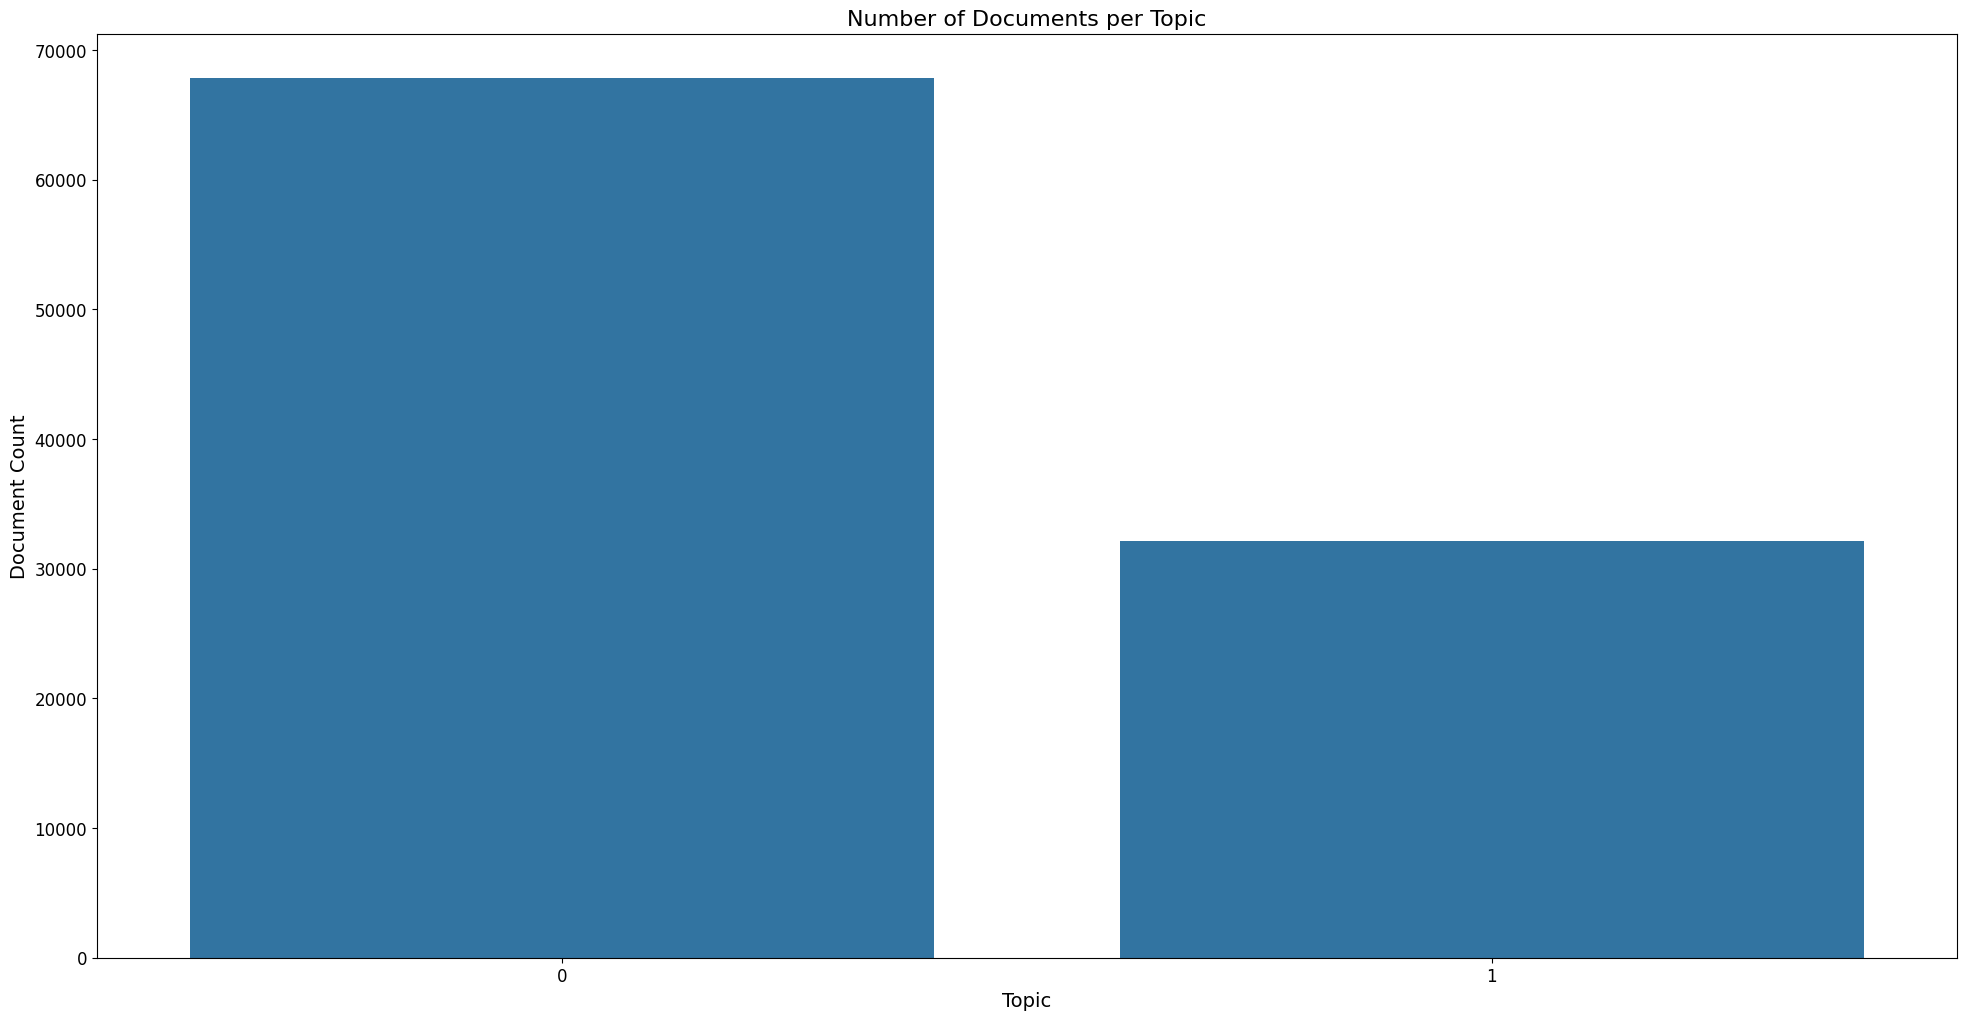

<Figure size 2000x1200 with 0 Axes>

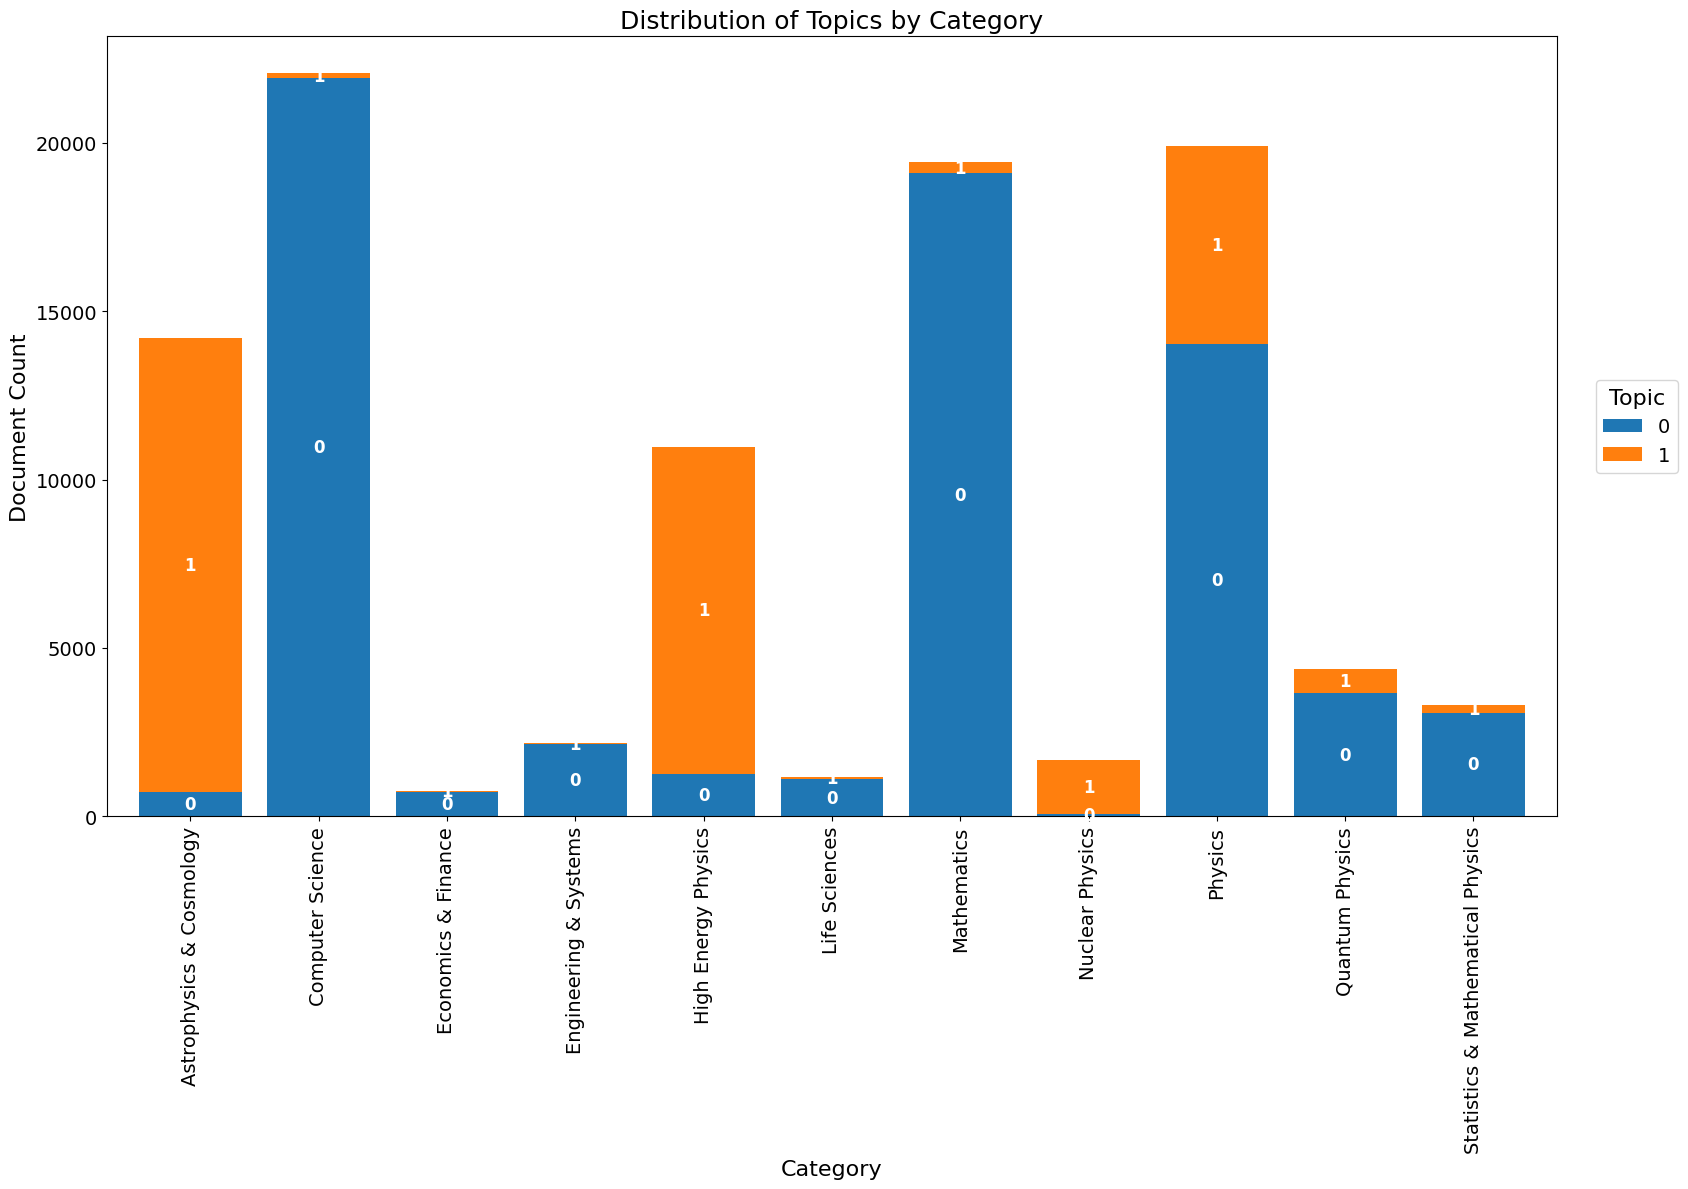

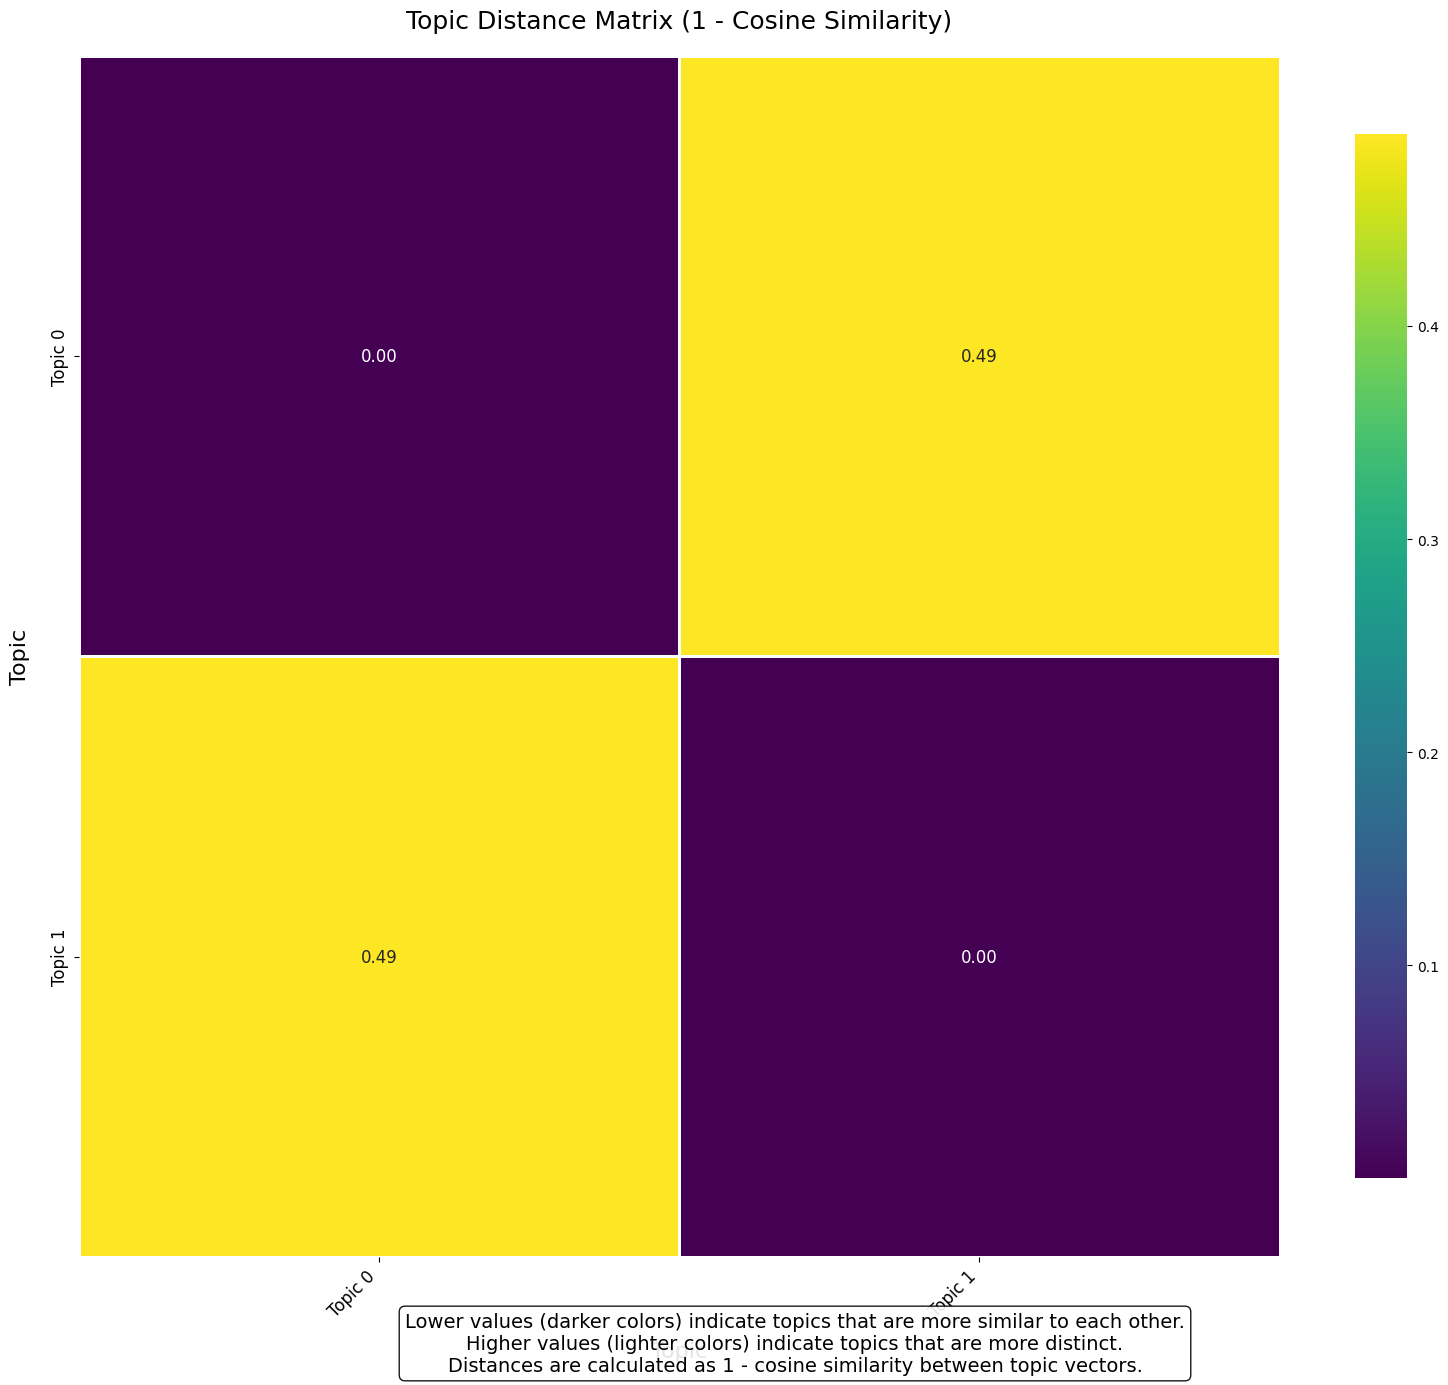

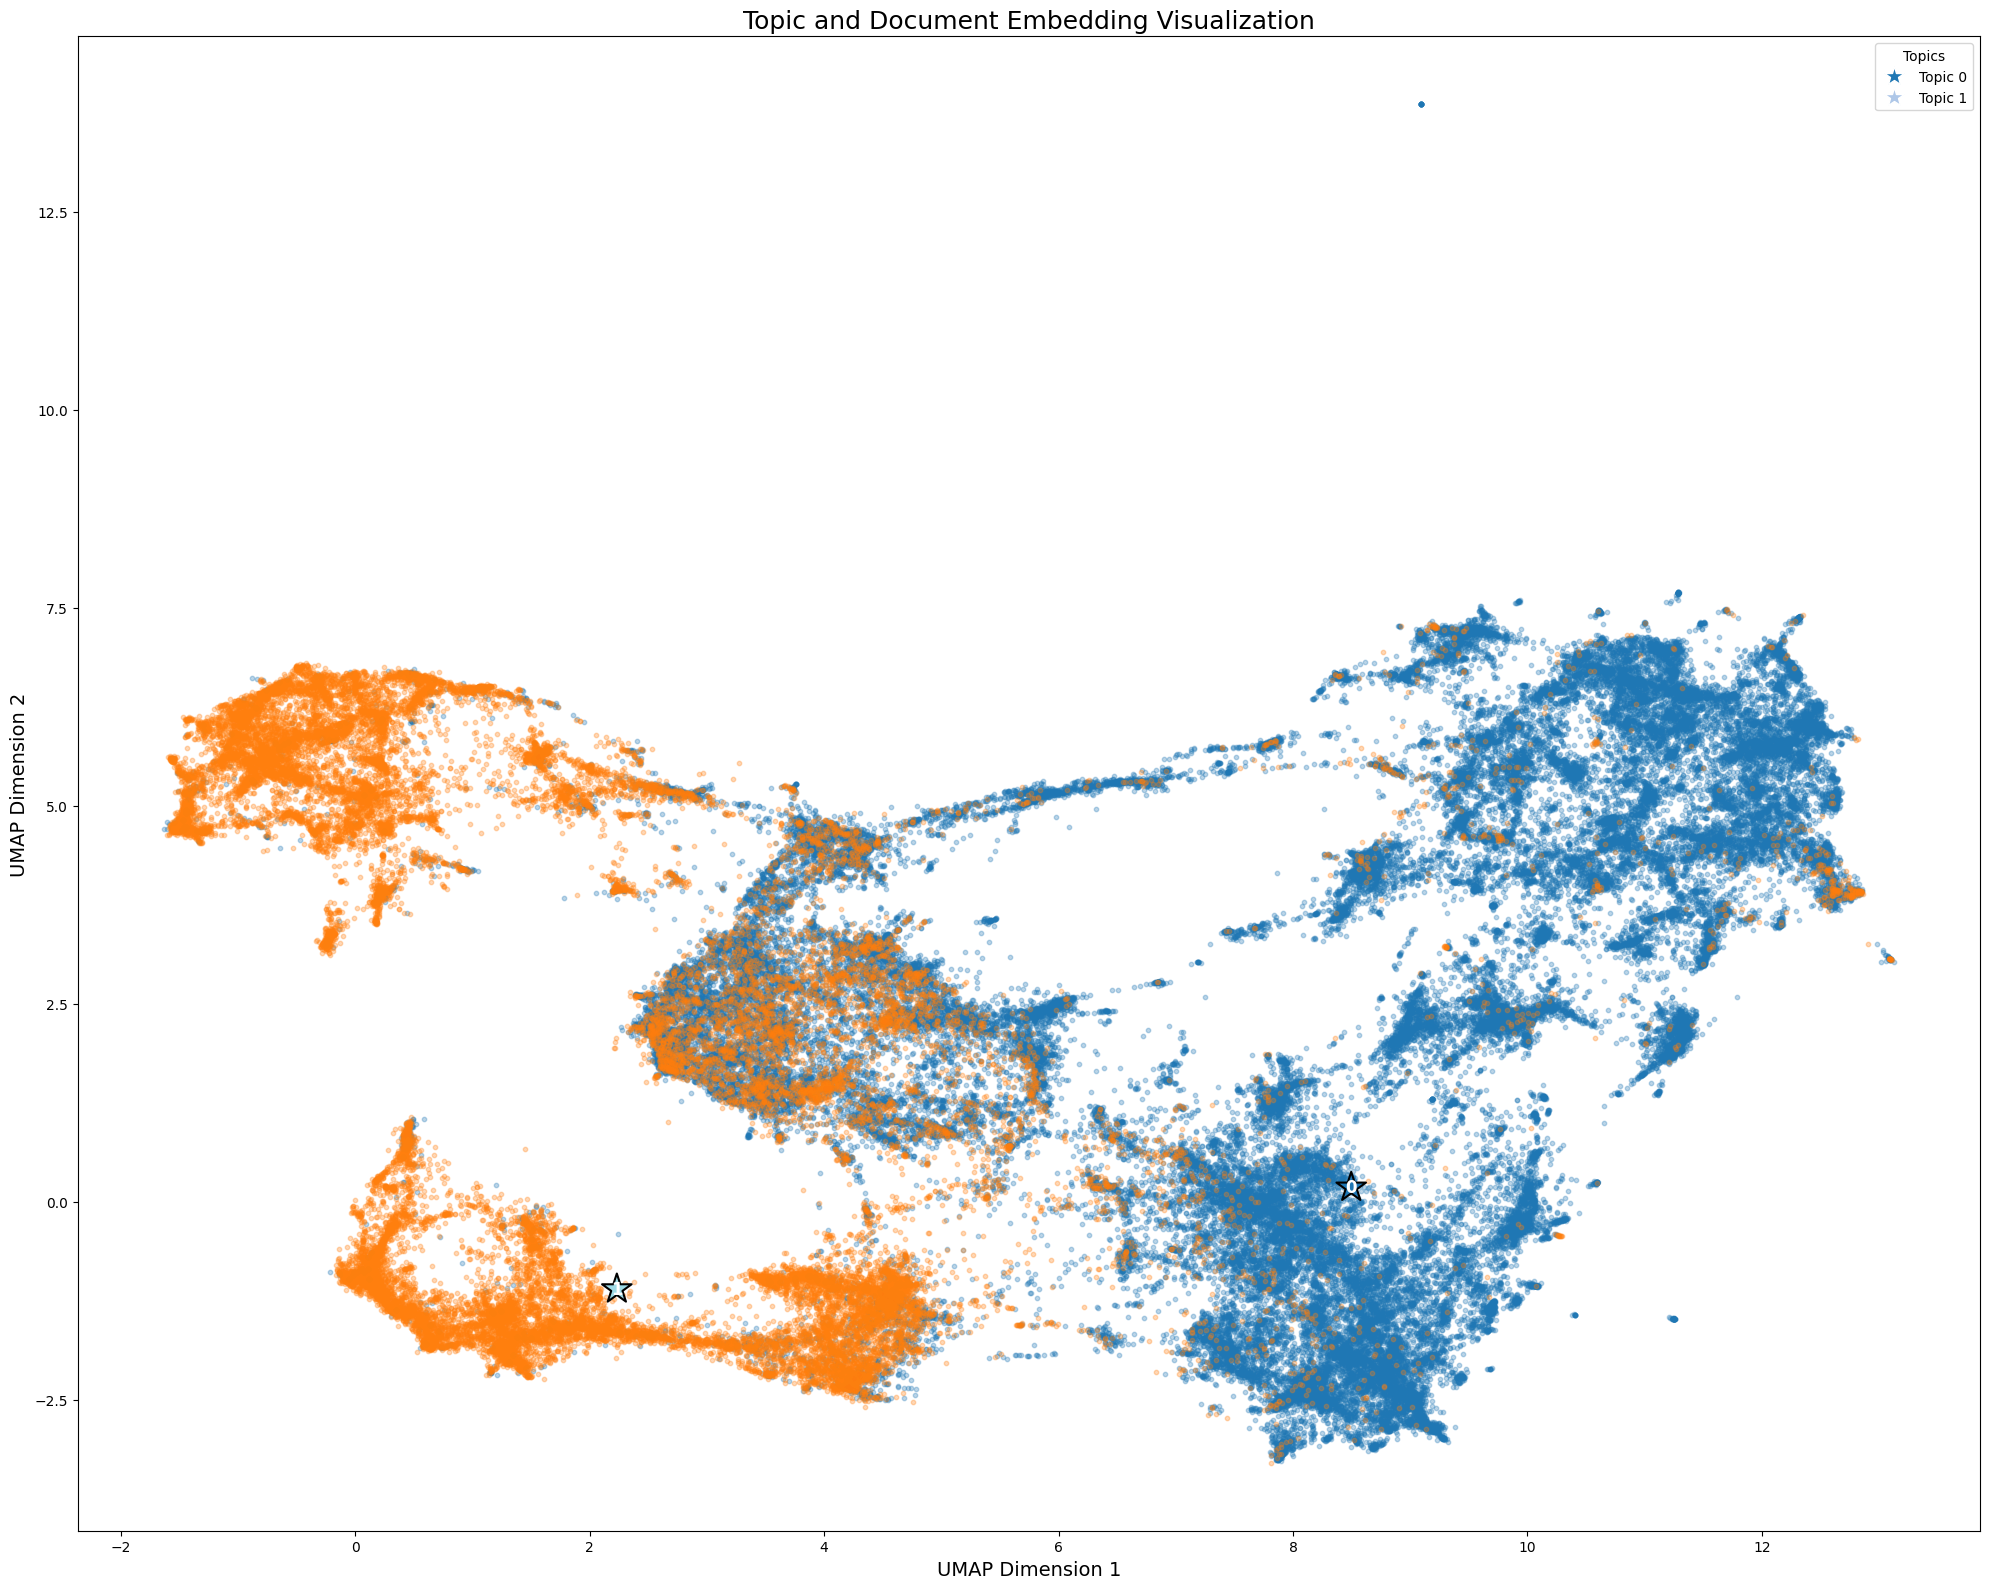

In [ ]:
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from top2vec import Top2Vec
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import umap
import traceback

warnings.filterwarnings('ignore')
np.random.seed(42)

# Dataset-specific variables
TEXT_COLUMN = 'processed_abstract'                            # Column containing text data
CATEGORY_COLUMN = 'merged_category'                 # Column containing category data
TARGET_TOPICS = 12                              # Target number of topics

# Hyperparameter ranges to test
MIN_COUNT_RANGE = [20]                          # Controls vocabulary size
N_NEIGHBORS_RANGE = [5]                         # Affects clustering density

# 1. Prepare text data
df = df.dropna(subset=['processed_abstract'])
documents = df[TEXT_COLUMN].tolist()
document_ids = np.arange(len(documents))

# 2. Function to train and evaluate Top2Vec models
def evaluate_top2vec_models(documents, document_ids, min_count_range, n_neighbors_range, target_topics=12, verbose=True):
    """
    Train and evaluate Top2Vec models with different hyperparameters

    Parameters:
    -----------
    documents: list of str
        Document texts
    document_ids: list or array
        Document IDs
    min_count_range: list of int
        Range of min_count values to try (controls vocab size)
    n_neighbors_range: list of int
        Range of n_neighbors values to try (affects clustering)
    target_topics: int
        Target number of topics (we'll use hierarchical clustering to limit)
    verbose: bool
        Whether to print progress

    Returns:
    --------
    DataFrame with evaluation results
    """
    results = []

    # Create vectorizer for TC and TD calculations
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=2,
        stop_words='english',
        max_features=5000
    )
    X = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    for min_count in min_count_range:
        for n_neighbors in n_neighbors_range:
            if verbose:
                print(f"Training model with min_count={min_count}, n_neighbors={n_neighbors}...")

            try:
                # Try different min_cluster_size values
                min_cluster_sizes = [200, 300]
                best_model = None
                best_diff = float('inf')
                best_n_topics = 0
                best_mcs = 0

                for mcs in min_cluster_sizes:
                    if verbose:
                        print(f"  Trying min_cluster_size={mcs}...")

                    try:
                        model = Top2Vec(
                            documents=documents,
                            document_ids=document_ids,
                            min_count=min_count,
                            embedding_model='doc2vec',
                            umap_args={'n_neighbors': n_neighbors, 'n_components': 5, 'metric': 'cosine'},
                            hdbscan_args={'min_cluster_size': mcs, 'metric': 'euclidean', 'cluster_selection_method': 'eom'},
                            workers=8,
                            verbose=False  # Set to False to reduce output
                        )

                        n_topics = model.get_num_topics()

                        if verbose:
                            print(f"    Found {n_topics} topics")

                        # Calculate difference from target
                        diff = abs(n_topics - target_topics)

                        # If this model is closer to target_topics or has fewer topics, keep it
                        if (diff < best_diff or (n_topics <= target_topics and best_n_topics > target_topics)) and n_topics > 0:
                            best_diff = diff
                            best_model = model
                            best_n_topics = n_topics
                            best_mcs = mcs

                        # If we're already at or below target, no need to try larger min_cluster_size
                        if n_topics <= target_topics and n_topics > 0:
                            break
                    except Exception as inner_e:
                        if verbose:
                            print(f"    Error with min_cluster_size={mcs}: {str(inner_e)}")

                # If we found a model
                if best_model is not None:
                    model = best_model
                    n_topics_original = best_n_topics

                    if verbose:
                        print(f"  Best model has {n_topics_original} topics with min_cluster_size={best_mcs}")

                    # If we have more topics than target, select only the top N
                    n_topics = min(n_topics_original, target_topics)

                    # Get word vectors for topic coherence and diversity
                    topic_words_dict = {}
                    topic_word_dist_matrix = []

                    # Get topic word and document info
                    topic_nums = range(n_topics_original)  # All available topics

                    # Get document count per topic for selecting the largest ones
                    topic_counts = {}

                    # Get all document-topic assignments
                    doc_topics = model.get_documents_topics(document_ids)[0]  # Get topic assignments

                    # Count documents per topic
                    for topic_idx in doc_topics:
                        if topic_idx in topic_counts:
                            topic_counts[topic_idx] += 1
                        else:
                            topic_counts[topic_idx] = 1

                    if verbose:
                        print(f"  Topic counts: {topic_counts}")

                    # Create a list of (topic_idx, count) pairs from the dictionary
                    topic_size_pairs = [(topic_idx, count) for topic_idx, count in topic_counts.items()]

                    # Sort by count in descending order
                    topic_size_pairs.sort(key=lambda x: x[1], reverse=True)

                    if verbose:
                        print(f"  Topics sorted by size: {topic_size_pairs}")

                    # Take only the largest n_topics topics
                    selected_topics = [pair[0] for pair in topic_size_pairs[:n_topics]]

                    # Ensure we have up to n_topics topics
                    if len(selected_topics) < n_topics:
                        # If we have fewer topics than requested, adjust n_topics
                        n_topics = len(selected_topics)

                    if verbose:
                        print(f"  Selected topics: {selected_topics}")

                    # Convert Top2Vec word scores to format similar to LDA components for TC/TD calculation
                    for i, topic_idx in enumerate(selected_topics):
                        words, word_scores = model.get_topics()[0][topic_idx], model.get_topics()[1][topic_idx]
                        topic_words_dict[i] = words

                        # Create a topic-word distribution vector
                        topic_word_dist = np.zeros(len(feature_names))
                        for word, score in zip(words, word_scores):
                            if word in vectorizer.vocabulary_:
                                word_idx = vectorizer.vocabulary_[word]
                                topic_word_dist[word_idx] = score

                        # Normalize to make it a probability distribution
                        sum_score = np.sum(topic_word_dist)
                        if sum_score > 0:
                            topic_word_dist = topic_word_dist / sum_score

                        topic_word_dist_matrix.append(topic_word_dist)

                    if len(topic_word_dist_matrix) > 0:
                        topic_word_dist_matrix = np.array(topic_word_dist_matrix)

                        # Calculate the same metrics as for LDA
                        topic_coherence = calculate_topic_coherence(topic_word_dist_matrix, X, feature_names)
                        avg_coherence = np.mean(topic_coherence) if len(topic_coherence) > 0 else 0
                        topic_diversity = calculate_topic_diversity(topic_word_dist_matrix)

                        # Store results
                        results.append({
                            'min_count': min_count,
                            'n_neighbors': n_neighbors,
                            'min_cluster_size': best_mcs,
                            'n_topics_original': n_topics_original,
                            'n_topics': n_topics,
                            'avg_coherence': avg_coherence,
                            'topic_diversity': topic_diversity,
                            'model': model,
                            'topic_words_dict': topic_words_dict,
                            'topic_word_dist_matrix': topic_word_dist_matrix,
                            'selected_topics': selected_topics
                        })

                        if verbose:
                            print(f"  Final number of topics: {n_topics}")
                            print(f"  Avg coherence: {avg_coherence:.4f}")
                            print(f"  Topic diversity: {topic_diversity:.4f}")
                    else:
                        if verbose:
                            print("  No topics were selected after filtering")
                else:
                    if verbose:
                        print("  No suitable model found with these parameters")

            except Exception as e:
                if verbose:
                    print(f"  Error with parameters min_count={min_count}, n_neighbors={n_neighbors}: {str(e)}")
                    traceback.print_exc()

    return pd.DataFrame(results) if results else pd.DataFrame({
        'min_count': [],
        'n_neighbors': [],
        'min_cluster_size': [],
        'n_topics_original': [],
        'n_topics': [],
        'avg_coherence': [],
        'topic_diversity': [],
        'model': [],
        'topic_words_dict': [],
        'topic_word_dist_matrix': [],
        'selected_topics': []
    })

# Topic Coherence calculation function
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]

    for topic_idx, topic_dist in enumerate(topic_word_dist):
        # Get top N words for this topic
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(top_word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(top_word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_dist in topic_word_dist:
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]
        topics_top_words.append(set(top_word_indices))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topic_word_dist) * top_n) if len(topic_word_dist) > 0 else 0

# 3. Run evaluation
print("Evaluating Top2Vec models with different parameters...")
evaluation_results = evaluate_top2vec_models(
    documents=documents,
    document_ids=document_ids,
    min_count_range=MIN_COUNT_RANGE,
    n_neighbors_range=N_NEIGHBORS_RANGE,
    target_topics=TARGET_TOPICS
)

# Check if we have results before proceeding
if len(evaluation_results) == 0:
    print("No valid models were found. Try adjusting the parameters.")
else:
    # 4. Plot evaluation metrics
    if len(evaluation_results) > 1:
        # Create a pivot table for visualization
        try:
            coherence_pivot = evaluation_results.pivot(
                index='min_count',
                columns='n_neighbors',
                values='avg_coherence'
            )

            diversity_pivot = evaluation_results.pivot(
                index='min_count',
                columns='n_neighbors',
                values='topic_diversity'
            )

            n_topics_pivot = evaluation_results.pivot(
                index='min_count',
                columns='n_neighbors',
                values='n_topics'
            )

            # Plot heatmaps
            fig, axes = plt.subplots(1, 3, figsize=(24, 8))

            # Topic count heatmap
            sns.heatmap(n_topics_pivot, annot=True, cmap="YlGnBu", ax=axes[0])
            axes[0].set_title('Number of Topics', fontsize=14)
            axes[0].set_xlabel('n_neighbors', fontsize=12)
            axes[0].set_ylabel('min_count', fontsize=12)

            # Coherence heatmap
            sns.heatmap(coherence_pivot, annot=True, cmap="YlGnBu", ax=axes[1])
            axes[1].set_title('Average Topic Coherence (higher is better)', fontsize=14)
            axes[1].set_xlabel('n_neighbors', fontsize=12)
            axes[1].set_ylabel('min_count', fontsize=12)

            # Diversity heatmap
            sns.heatmap(diversity_pivot, annot=True, cmap="YlGnBu", ax=axes[2])
            axes[2].set_title('Topic Diversity (higher is better)', fontsize=14)
            axes[2].set_xlabel('n_neighbors', fontsize=12)
            axes[2].set_ylabel('min_count', fontsize=12)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not create heatmaps: {str(e)}")
            print("Continuing with best model selection...")

    # 5. Calculate combined score for each model
    # Normalize metrics
    if len(evaluation_results) > 1:
        try:
            e_min = evaluation_results['avg_coherence'].min()
            e_max = evaluation_results['avg_coherence'].max()
            d_min = evaluation_results['topic_diversity'].min()
            d_max = evaluation_results['topic_diversity'].max()

            # Avoid division by zero
            e_range = e_max - e_min if e_max > e_min else 1
            d_range = d_max - d_min if d_max > d_min else 1

            normalized_coherence = (evaluation_results['avg_coherence'] - e_min) / e_range
            normalized_diversity = (evaluation_results['topic_diversity'] - d_min) / d_range

            # Combined score (equal weights for coherence and diversity)
            evaluation_results['combined_score'] = (normalized_coherence + normalized_diversity) / 2

            # Find optimal model
            best_model_idx = evaluation_results['combined_score'].idxmax()
            best_model_params = evaluation_results.loc[best_model_idx]
        except Exception as e:
            print(f"Error calculating combined score: {str(e)}")
            best_model_params = evaluation_results.iloc[0]
    else:
        # If only one model, use it directly
        best_model_params = evaluation_results.iloc[0]

    # 6. Find optimal model
    print("\nBest model parameters:")
    print(f"min_count: {best_model_params['min_count']}")
    print(f"n_neighbors: {best_model_params['n_neighbors']}")
    print(f"min_cluster_size: {best_model_params['min_cluster_size']}")
    print(f"Original number of topics: {best_model_params['n_topics_original']}")
    print(f"Selected number of topics: {best_model_params['n_topics']}")
    print(f"Average coherence: {best_model_params['avg_coherence']:.4f}")
    print(f"Topic diversity: {best_model_params['topic_diversity']:.4f}")

    # 7. Get the best model
    best_model = best_model_params['model']
    selected_topics = best_model_params['selected_topics']

    # 8. Display topics
    print("\nTop 10 words per topic:")
    topic_words = {}
    for i, topic_idx in enumerate(selected_topics):
        words, word_scores = best_model.get_topics()[0][topic_idx], best_model.get_topics()[1][topic_idx]
        topic_words[i] = words[:10]
        print(f"Topic {i} (original #{topic_idx}): {' '.join(words[:10])}")

    # 9. Document distribution across topics
    # Get original topic assignments
    original_topic_distribution = best_model.get_documents_topics(document_ids)[0]

    # Map original topic IDs to our selected topics (0 to n_topics-1)
    topic_id_mapping = {old_id: new_id for new_id, old_id in enumerate(selected_topics)}

    # Create a new topic distribution array, mapping original topics to our selected ones
    # Any document with a topic not in our selected_topics will be assigned -1 (no topic)
    mapped_topic_distribution = np.array([
        topic_id_mapping.get(topic_id, -1) for topic_id in original_topic_distribution
    ])

    document_topic_df = pd.DataFrame({
        'document_id': range(len(documents)),
        'topic': mapped_topic_distribution,
        'category': df[CATEGORY_COLUMN]
    })

    # Filter out documents that don't belong to our selected topics
    filtered_document_topic_df = document_topic_df[document_topic_df['topic'] >= 0]

    print(f"\nTotal documents: {len(documents)}")
    print(f"Documents assigned to selected topics: {len(filtered_document_topic_df)}")
    print(f"Percentage of documents covered: {len(filtered_document_topic_df)/len(documents)*100:.2f}%")

    # If we have documents
    if len(filtered_document_topic_df) > 0:
        # Plot document count by topic
        plt.figure(figsize=(24, 12))
        sns.countplot(x='topic', data=filtered_document_topic_df)
        plt.title('Number of Documents per Topic', fontsize=16)
        plt.xlabel('Topic', fontsize=14)
        plt.ylabel('Document Count', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

        # 10. Analysis by category
        plt.figure(figsize=(20, 12))
        category_topic_counts = pd.crosstab(filtered_document_topic_df['category'], filtered_document_topic_df['topic'])
        ax = category_topic_counts.plot(
            kind='bar',
            stacked=True,
            figsize=(20, 12),
            width=0.8
        )

        plt.title('Distribution of Topics by Category', fontsize=18)
        plt.xlabel('Category', fontsize=16)
        plt.ylabel('Document Count', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(
            title='Topic',
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=14,
            title_fontsize=16
        )

        # Add topic numbers to each segment
        for i, container in enumerate(ax.containers):
            topic_number = i
            for j, rect in enumerate(container):
                height = rect.get_height()
                if height > 4:
                    # Get the center x,y coordinates of the bar segment
                    x = rect.get_x() + rect.get_width()/2
                    # For stacked bars, we need to find the vertical center of this segment
                    y = rect.get_y() + height/2
                    # Add the topic number at the center of the segment
                    ax.text(x, y, str(topic_number),
                           ha='center',
                           va='center',
                           color='white',
                           fontweight='bold',
                           fontsize=12)

        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

        # 11. Topic distance visualization
        # Get topic vectors for selected topics
        topic_vectors = np.array([best_model.topic_vectors[i] for i in selected_topics])

        # Calculate cosine similarity between topics
        topic_similarities = cosine_similarity(topic_vectors)

        # Convert to distances (1 - similarity)
        topic_distances = 1 - topic_similarities

        # Plot distance matrix
        plt.figure(figsize=(16, 14))
        topic_labels = [f"Topic {i}" for i in range(len(selected_topics))]

        ax = sns.heatmap(
            topic_distances,
            annot=True,
            cmap='viridis',
            fmt='.2f',
            linewidths=1,
            linecolor='white',
            cbar_kws={'shrink': 0.8},
            square=True,
            xticklabels=topic_labels,
            yticklabels=topic_labels,
            annot_kws={"size": 12}
        )

        # Improve the appearance of the plot
        plt.title('Topic Distance Matrix (1 - Cosine Similarity)', fontsize=18, pad=20)
        plt.xlabel('Topic', fontsize=16, labelpad=15)
        plt.ylabel('Topic', fontsize=16, labelpad=15)
        plt.xticks(fontsize=12, rotation=45, ha='right')
        plt.yticks(fontsize=12)
        plt.figtext(
            0.5, 0.01,
            "Lower values (darker colors) indicate topics that are more similar to each other.\n"
            "Higher values (lighter colors) indicate topics that are more distinct.\n"
            "Distances are calculated as 1 - cosine similarity between topic vectors.",
            ha='center',
            fontsize=14,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
        )

        plt.tight_layout()
        plt.show()

        # 12. Visualize topic and document embeddings in 2D
        # Filter documents to only those assigned to our selected topics
        filtered_doc_ids = filtered_document_topic_df['document_id'].values
        filtered_doc_vectors = best_model.document_vectors[filtered_doc_ids]

        # Combine filtered document and topic vectors
        combined_vectors = np.vstack([filtered_doc_vectors, topic_vectors])

        # Use UMAP to reduce to 2D
        reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
        embedding = reducer.fit_transform(combined_vectors)

        # Split back into documents and topics
        doc_embedding = embedding[:len(filtered_doc_ids)]
        topic_embedding = embedding[len(filtered_doc_ids):]

        # Get mapped topic IDs for our filtered documents
        doc_topics = filtered_document_topic_df['topic'].values

        # Create plot
        plt.figure(figsize=(20, 16))

        # Plot documents colored by topic
        for topic_idx in range(len(selected_topics)):
            topic_docs = doc_topics == topic_idx
            if np.any(topic_docs):  # Only plot if there are documents with this topic
                plt.scatter(
                    doc_embedding[topic_docs, 0],
                    doc_embedding[topic_docs, 1],
                    alpha=0.3,
                    s=10,
                    label=f"Documents in Topic {topic_idx}"
                )

        # Plot topic centers with larger markers
        plt.scatter(
            topic_embedding[:, 0],
            topic_embedding[:, 1],
            c=range(len(selected_topics)),
            cmap='tab20',
            s=500,
            marker='*',
            edgecolor='black',
            linewidth=1.5
        )

        # Add topic numbers
        for i in range(len(selected_topics)):
            plt.text(
                topic_embedding[i, 0],
                topic_embedding[i, 1],
                str(i),
                fontsize=12,
                ha='center',
                va='center',
                color='white',
                fontweight='bold'
            )

        plt.title('Topic and Document Embedding Visualization', fontsize=18)
        plt.xlabel('UMAP Dimension 1', fontsize=14)
        plt.ylabel('UMAP Dimension 2', fontsize=14)

        # Add a small legend for topics only
        topic_legend = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor=plt.cm.tab20(i),
                                   markersize=15, label=f"Topic {i}") for i in range(min(10, len(selected_topics)))]
        plt.legend(handles=topic_legend, title="Topics", loc='upper right')

        plt.tight_layout()
        plt.show()
    else:
        print("No documents were assigned to the selected topics. Try adjusting the parameters.")

# BERTopic

In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan plotly spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from google.colab import drive
import pandas as pd

try:
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/arxiv_preprocessed.csv'
    df = pd.read_csv(file_path).sample(n=100000, random_state=42)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_FILE}")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Mounted at /content/drive
Dataset loaded successfully. Shape: (100000, 4)
                                                  abstract update_date  \
916746     Continuing the work of \cite{7} and \cite{8}...  2017-11-28   
368210     We compute the dependence of the Higgs to tw...  2013-10-31   
2483072    The heavy quark production in ultraperiphera...  2009-01-07   
1906818    This paper introduces PROMISE ($\textbf{Pr}$...  2024-03-15   
951855     Universe history in $R^2$-gravity is studied...  2018-11-27   

                                        processed_abstract  \
916746   continuing work 7 8 derive analogue classical ...   
368210   compute dependence higgs decay rate heavy top ...   
2483072  heavy quark production ultraperipheral heavy i...   
1906818  paper introduces promise econditioned stochast...   
951855   universe history studied beginning present epo...   

                  merged_category  
916746                Mathematics  
368210        High Energy Physics  


Processing 99999 documents
Loading sentence transformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-04-23 19:28:05,926 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting BERTopic model...


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2025-04-23 19:30:24,248 - BERTopic - Embedding - Completed ✓
2025-04-23 19:30:24,260 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-23 19:32:56,660 - BERTopic - Dimensionality - Completed ✓
2025-04-23 19:32:56,666 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-23 19:33:09,839 - BERTopic - Cluster - Completed ✓
2025-04-23 19:33:09,840 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-23 19:33:17,553 - BERTopic - Representation - Completed ✓
2025-04-23 19:33:17,555 - BERTopic - Topic reduction - Reducing number of topics
2025-04-23 19:33:17,714 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-23 19:33:28,904 - BERTopic - Representation - Completed ✓
2025-04-23 19:33:28,917 - BERTopic - Topic reduction - Reduced number of topics from 704 to 20



======= Topic Information =======
Number of topics: 19
   Topic  Count                                        Name  \
0     -1  52444                -1_data_method_study_quantum   
1      0  11989                   0_mass_galaxy_star_energy   
2      1   8823                1_image_method_learning_data   
3      2   4907                2_graph_group_algebra_vertex   
4      3   4006       3_magnetic_graphene_temperature_phase   
5      4   3209            4_network_problem_control_method   
6      5   2455  5_quantum_entanglement_optical_measurement   
7      6   2297          6_operator_solution_space_function   
8      7   1972    7_random_process_stochastic_distribution   
9      8   1959           8_method_algorithm_problem_market   

                                      Representation  \
0  [data, method, study, quantum, function, probl...   
1  [mass, galaxy, star, energy, theory, spectrum,...   
2  [image, method, learning, data, network, task,...   
3  [graph, group, algebra,

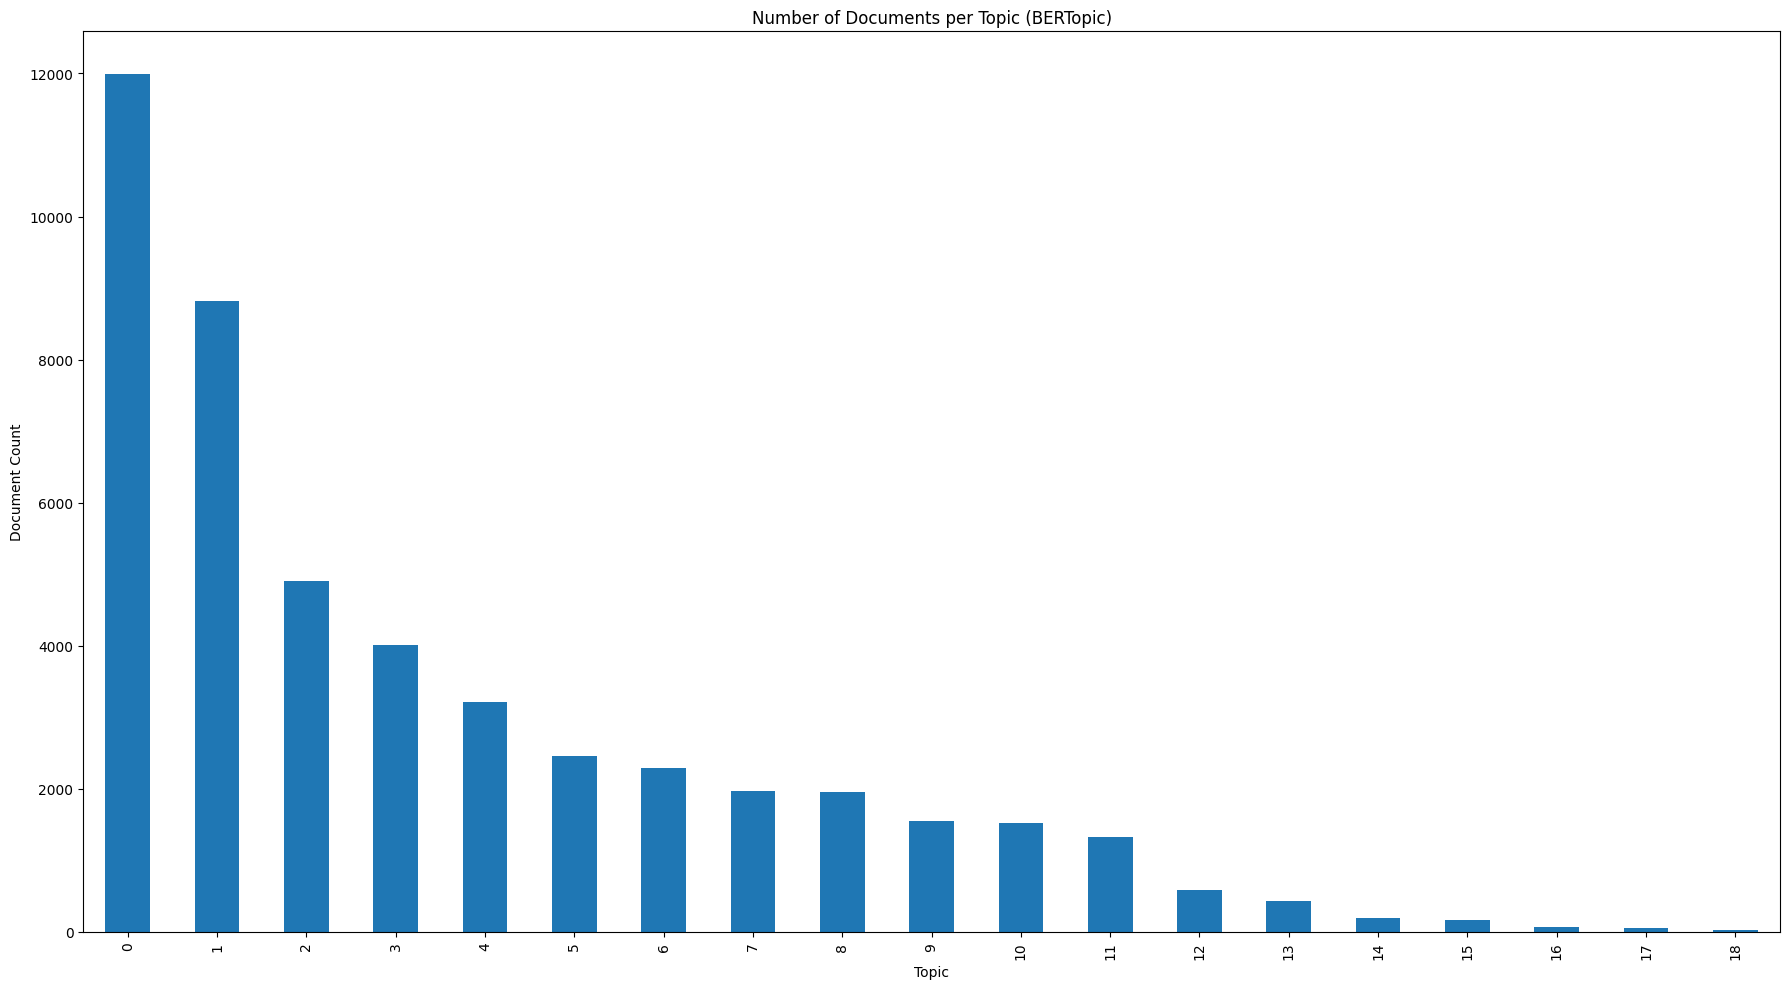

<Figure size 2000x1200 with 0 Axes>

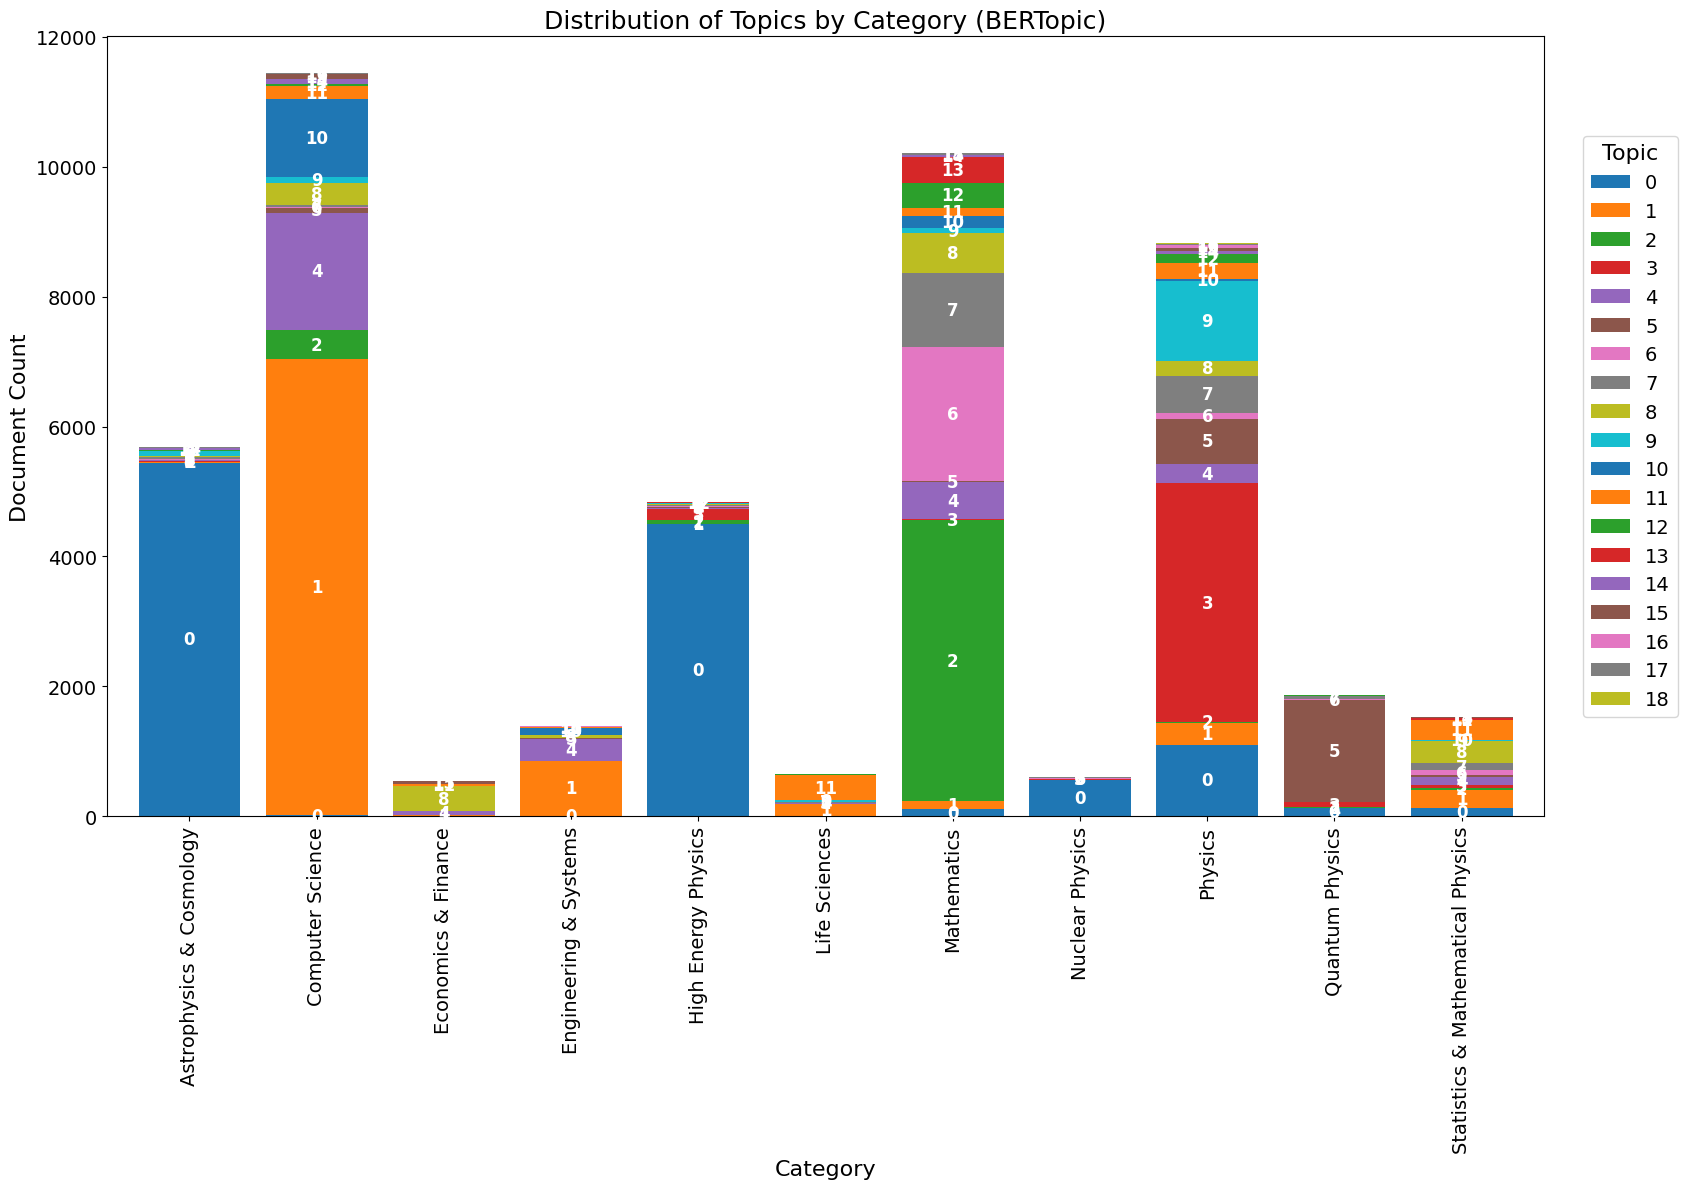

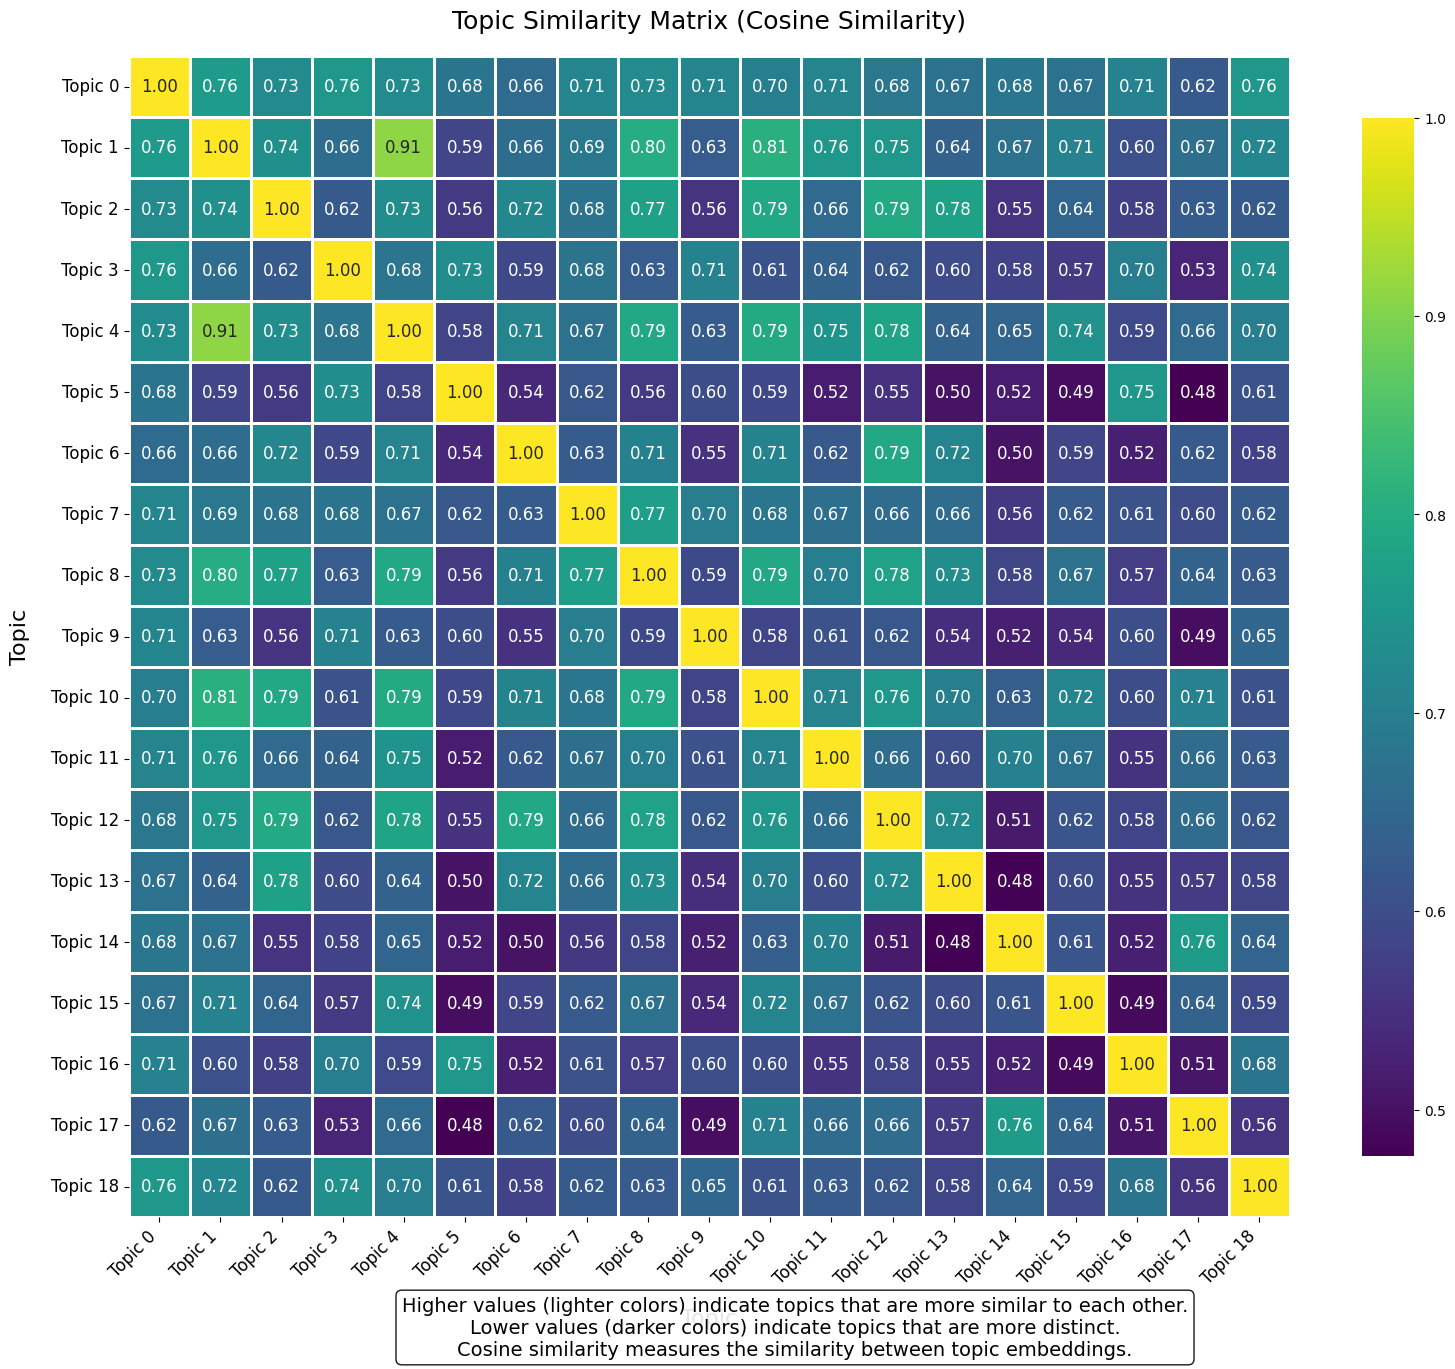

Network visualization not available in this version of BERTopic. Skipping.

======= Topic Coherence and Diversity Metrics =======
Creating document-term matrix for coherence calculation...
Document-term matrix shape: (99999, 5000)
Calculating Topic Coherence...
Calculating Topic Diversity...

Topic Coherence scores per topic:
Topic 0: 0.1247
Topic 1: 0.2497
Topic 2: 0.0931
Topic 3: 0.1733
Topic 4: 0.1566
Topic 5: 0.1679
Topic 6: 0.1181
Topic 7: 0.1094
Topic 8: 0.1080
Topic 9: 0.1887
Topic 10: 0.0957
Topic 11: 0.1169
Topic 12: 0.1142
Topic 13: 0.1273
Topic 14: 0.2742
Topic 15: 0.1981
Topic 16: 0.2388
Topic 17: 0.0589
Topic 18: 0.1487
Average Topic Coherence: 0.1507
Topic Diversity: 0.3242


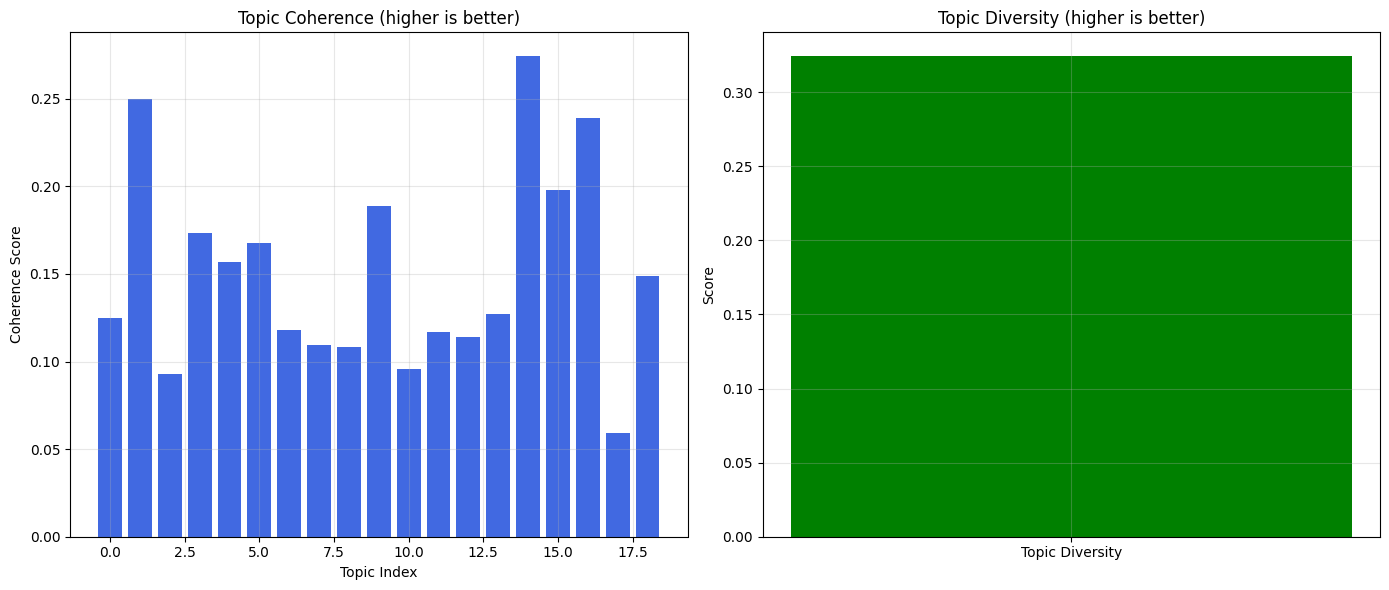


Execution time: 377.04 seconds

======= BERTopic Analysis Complete =======


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, coo_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time

# BERTopic and related libraries
from bertopic.representation import KeyBERTInspired, PartOfSpeech
from sklearn.metrics.pairwise import cosine_similarity
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP

warnings.filterwarnings('ignore')
np.random.seed(42)

# Start timer to measure performance
start_time = time.time()

# 1. Prepare text data
df = df.dropna(subset=['processed_abstract'])
documents = df['processed_abstract'].tolist()
categories = df['merged_category'].tolist()

print(f"Processing {len(documents)} documents")

# 2. Initialize embedding model
# Choose other models based on our needs: https://www.sbert.net/docs/pretrained_models.html
print("Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Smaller, faster model

# 3. Set up dimensionality reduction
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# 4. Set up clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# 5. Set up vectorization
vectorizer_model = CountVectorizer(
    max_df=0.95,            # Ignore terms that appear in more than 95% of documents
    min_df=2,               # Ignore terms that appear in fewer than 2 documents
    stop_words='english',
    max_features=5000       # Limit vocabulary size
)

# 6. Set up topic representation - using multiple approaches for better topics
representation_model = [
    KeyBERTInspired(),
    PartOfSpeech('en_core_web_sm')  # Need to download this: python -m spacy download en_core_web_sm
]

# 7. Create the BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ClassTfidfTransformer(),
    representation_model=representation_model,
    nr_topics=20,  # This limits the number of topics to 20
    verbose=True
)

# 8. Fit the model to our documents
print("Fitting BERTopic model...")
topics, probs = topic_model.fit_transform(documents)

# 9. Get information about the topics
topic_info = topic_model.get_topic_info()
print("\n======= Topic Information =======")
print(f"Number of topics: {len(topic_info) - 1}")  # -1 because BERTopic includes an "outlier" topic (-1)
print(topic_info.head(10))

# 10. Display top terms per topic (like in your LDA code)
print("\n======= Top Terms Per Topic =======")
for topic_id in topic_info['Topic'].unique():
    if topic_id != -1:  # Skip the outlier topic
        print(f"Topic {topic_id}: {', '.join([word for word, _ in topic_model.get_topic(topic_id)[:10]])}")

# 11. Analyze document distribution across topics (similar to your LDA analysis)
# Count documents per topic
topic_counts = pd.Series(topics).value_counts().sort_index()
topic_counts = topic_counts[topic_counts.index != -1]  # Remove outlier topic

# Plot document count by topic
plt.figure(figsize=(18, 10))
topic_counts.plot(kind='bar')
plt.title('Number of Documents per Topic (BERTopic)')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.tight_layout()
plt.show()
plt.close()

# 12. Analysis by category
# Create a DataFrame with document-topic distribution
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': topics,
    'category': categories
})

# Remove outliers for clearer visualization
topic_df_filtered = topic_df[topic_df['dominant_topic'] != -1]

# Plot topic distribution by category
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df_filtered['category'], topic_df_filtered['dominant_topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category (BERTopic)', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Position the legend outside the plot to the right
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = category_topic_counts.columns[i]
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
plt.close()

# 13. Visualize topic similarity using BERTopic's built-in functionality
topic_model.visualize_topics().write_html("bertopic_topic_visualization.html")

# 14. Topic distance visualization (similar to your LDA implementation)
# Get embeddings for each topic
topic_embeddings = {}
for topic_id in topic_info['Topic'].unique():
    if topic_id != -1:  # Skip the outlier topic
        # Get words in the topic
        words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
        # Get embeddings for these words
        word_embeddings = embedding_model.encode(words)
        # Average the embeddings to get a topic embedding
        topic_embeddings[topic_id] = np.mean(word_embeddings, axis=0)

# Calculate similarity matrix
topic_ids = sorted(list(topic_embeddings.keys()))
similarity_matrix = np.zeros((len(topic_ids), len(topic_ids)))

for i, topic_i in enumerate(topic_ids):
    for j, topic_j in enumerate(topic_ids):
        # Calculate cosine similarity between topic embeddings
        similarity = cosine_similarity([topic_embeddings[topic_i]], [topic_embeddings[topic_j]])[0][0]
        similarity_matrix[i, j] = similarity

# Plot similarity matrix
plt.figure(figsize=(16, 14))
topic_labels = [f"Topic {i}" for i in topic_ids]

ax = sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

# Improve the appearance of the plot
plt.title('Topic Similarity Matrix (Cosine Similarity)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)

# Increase the font size of tick labels
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Add a text explanation in the figure
plt.figtext(
    0.5, 0.01,
    "Higher values (lighter colors) indicate topics that are more similar to each other.\n"
    "Lower values (darker colors) indicate topics that are more distinct.\n"
    "Cosine similarity measures the similarity between topic embeddings.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.show()
plt.close()

# 15. Additional BERTopic visualizations not available in LDA
# Topic hierarchy
topic_model.visualize_hierarchy().write_html("bertopic_hierarchy.html")

# Topic similarity network - using the correct method name
try:
    # Try newer method name if available
    topic_model.visualize_network().write_html("bertopic_network.html")
except AttributeError:
    try:
        # Try older method name if available
        topic_model.visualize_topics_network().write_html("bertopic_network.html")
    except AttributeError:
        print("Network visualization not available in this version of BERTopic. Skipping.")

# Topic distributions over time (if we have a timestamp column)
if 'timestamp' in df.columns:
    topics_over_time = topic_model.topics_over_time(documents, df['timestamp'], nr_bins=20)
    topic_model.visualize_topics_over_time(topics_over_time).write_html("bertopic_over_time.html")

# 16. Dynamic Topic Representation (if needed)
# topic_model.update_topics(documents, topics, n_gram_range=(1, 3))

# 17. Evaluate TC and TD metrics (similar to LDA implementation)
print("\n======= Topic Coherence and Diversity Metrics =======")

# Create document-term matrix for BERTopic (needed for coherence calculation)
print("Creating document-term matrix for coherence calculation...")
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english',
    max_features=5000
)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {X.shape}")

# Topic Coherence calculation function (reused from LDA implementation)
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]
    vocab_dict = {word: idx for idx, word in enumerate(feature_names)}

    for topic_id, topic_words in topic_word_dist.items():
        if topic_id == -1:  # Skip outlier topic
            continue

        # Get words and ensure they exist in the vocabulary
        top_words = [word for word, _ in topic_words[:top_n]]
        valid_words = [word for word in top_words if word in vocab_dict]

        # Skip if not enough valid words
        if len(valid_words) < 2:
            coherence_scores.append(0)
            continue

        # Get word indices in the vocabulary
        word_indices = [vocab_dict[word] for word in valid_words if word in vocab_dict]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function (adapted for BERTopic)
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_id, words in topic_word_dist.items():
        if topic_id == -1:  # Skip outlier topic
            continue
        top_words = [word for word, _ in words[:top_n]]
        topics_top_words.append(set(top_words))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topics_top_words) * top_n)

# Get topic-word distributions for BERTopic
topic_word_dist = {}
num_topics = 0
for topic_id in topic_info['Topic'].unique():
    if topic_id != -1:  # Skip outlier topic
        topic_word_dist[topic_id] = topic_model.get_topic(topic_id)
        num_topics += 1

# Calculate TC and TD metrics
print("Calculating Topic Coherence...")
coherence_scores = calculate_topic_coherence(topic_word_dist, X, feature_names)
avg_coherence = np.mean(coherence_scores)

print("Calculating Topic Diversity...")
topic_diversity = calculate_topic_diversity(topic_word_dist)

# Display TC and TD metrics
print("\nTopic Coherence scores per topic:")
for i, score in enumerate(coherence_scores):
    topic_id = list(topic_word_dist.keys())[i]
    print(f"Topic {topic_id}: {score:.4f}")
print(f"Average Topic Coherence: {avg_coherence:.4f}")
print(f"Topic Diversity: {topic_diversity:.4f}")

# Plot TC and TD metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(coherence_scores)), coherence_scores, color='royalblue')
plt.xlabel('Topic Index')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence (higher is better)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(['Topic Diversity'], [topic_diversity], color='green', width=0.4)
plt.ylabel('Score')
plt.title('Topic Diversity (higher is better)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

# Print execution time
end_time = time.time()
print(f"\nExecution time: {end_time - start_time:.2f} seconds")

print("\n======= BERTopic Analysis Complete =======")

# FASTopic

In [ ]:
!pip install fastopic topmost sentence-transformers scikit-learn pandas numpy matplotlib seaborn tqdm plotly bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
from google.colab import drive
import pandas as pd

try:
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/arxiv_preprocessed.csv'
    df = pd.read_csv(file_path).sample(n=100000, random_state=42)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print(f"Error: CSV file not found")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully. Shape: (100000, 4)
                                                  abstract update_date  \
916746     Continuing the work of \cite{7} and \cite{8}...  2017-11-28   
368210     We compute the dependence of the Higgs to tw...  2013-10-31   
2483072    The heavy quark production in ultraperiphera...  2009-01-07   
1906818    This paper introduces PROMISE ($\textbf{Pr}$...  2024-03-15   
951855     Universe history in $R^2$-gravity is studied...  2018-11-27   

                                        processed_abstract  \
916746   continuing work 7 8 derive analogue classical ...   
368210   compute dependence higgs decay rate heavy top ...   
2483072  heavy quark production ultraperipheral heavy i...   
1906818  paper introduces promise econditioned stochast...   
951855   universe history studied beginning present epo...   

     

In [ ]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from fastopic import FASTopic
from topmost.preprocess import Preprocess

warnings.filterwarnings('ignore')
np.random.seed(42)

# Create output directory if it doesn't exist
output_dir = "fastopic_outputs_v3_defaults"
os.makedirs(output_dir, exist_ok=True)

# Start timer to measure performance
start_time = time.time()

# 1. Prepare text data
print("Loading dataset...")
df = df.dropna(subset=['abstract'])

if 'abstract' in df.columns:
    print("Using original 'text' column for FASTopic.")
    documents = df['abstract'].tolist()
else:
    raise ValueError("Dataset must contain the 'text' column.")

categories = df['merged_category'].tolist()
print(f"Processing {len(documents)} documents")

# 2. Initialize FASTopic Preprocessor (USING DEFAULTS)
print("Initializing FASTopic Preprocessor (using defaults)...")
preprocess = Preprocess()

# 3. Initialize FASTopic model
print("Initializing FASTopic model...")
n_topics_target = 20 # Desired number of topics
topic_model = FASTopic(
    n_topics_target,
    preprocess,
    low_memory=True,
    low_memory_batch_size=10000)

# (Optional) Load embedding model separately if needed for similarity approx.
print("Loading sentence transformer model (for potential similarity calculation)...")
embedding_model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(embedding_model_name)


# 4. Fit the model to our documents (USING DEFAULT EPOCHS)
print("\nFitting FASTopic model (using default epochs)...")
top_words_list, doc_topic_dist = topic_model.fit_transform(documents)

# Derive dominant topic assignments
topics = np.argmax(doc_topic_dist, axis=1)
actual_num_topics = doc_topic_dist.shape[1]
print(f"Model fitting complete. Found {actual_num_topics} topics.")
if actual_num_topics != n_topics_target:
     print(f"Note: The actual number of topics ({actual_num_topics}) differs from the target ({n_topics_target}).")

# 5. Get information about the topics
print("\n======= Topic Information =======")
print(f"Number of topics found: {actual_num_topics}")

# 6. Display top terms per topic and store for TC/TD
print("\n======= Top Terms Per Topic =======")
topic_word_dist = {} # Store for later use (TC/TD)
num_words_to_display = 10
num_words_for_coherence = 10
num_words_for_diversity = 15

# Iterate through the actual number of topics found
for topic_id in range(actual_num_topics):
    try:
        # Call get_topic with only topic_idx
        all_topic_words_scores = topic_model.get_topic(topic_idx=topic_id)

        if all_topic_words_scores:
            # Slice for display
            display_words_scores = all_topic_words_scores[:num_words_to_display]
            # Store the needed number for metrics (get_topic might return more or less than 25)
            topic_word_dist[topic_id] = all_topic_words_scores # Store potentially more words for metrics flexibility

            print(f"Topic {topic_id}: {', '.join([word for word, _ in display_words_scores])}")
        else:
             print(f"Topic {topic_id}: No words returned by get_topic.")
             if topic_id < len(top_words_list) and top_words_list[topic_id]:
                 top_words_only = top_words_list[topic_id][:num_words_to_display]
                 print(f"Topic {topic_id} (from list): {', '.join(top_words_only)}")
             else:
                 print(f"Topic {topic_id}: Could not retrieve words.")

    except Exception as e:
        print(f"Error processing topic {topic_id}: {e}")

if not topic_word_dist:
    print("\nWarning: 'topic_word_dist' is empty. Similarity and TC/TD calculation will be skipped.")
else:
    print(f"\nSuccessfully retrieved top words for {len(topic_word_dist)} topics.")


# 7. Analyze document distribution across topics
print("\n======= Document Distribution Analysis =======")
topic_counts = pd.Series(topics).value_counts().sort_index()
plt.figure(figsize=(18, 10))
topic_counts.plot(kind='bar')
plt.title('Number of Documents per Topic (FASTopic - Defaults)')
plt.xlabel('Topic ID')
plt.ylabel('Document Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fastopic_doc_distribution.png"))
print(f"Saved document distribution plot to {os.path.join(output_dir, 'fastopic_doc_distribution.png')}")
plt.close()

# 8. Analysis by category
print("\n======= Category Distribution Analysis =======")
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': topics,
    'category': categories
})
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df['category'], topic_df['dominant_topic'])

if not category_topic_counts.empty:
    category_topic_counts = category_topic_counts.sort_index(axis=1)
    ax = category_topic_counts.plot(
        kind='bar', stacked=True, figsize=(20, 12), width=0.8, colormap='tab20'
    )
    plt.title('Distribution of Topics by Category (FASTopic - Defaults)', fontsize=18)
    plt.xlabel('Category', fontsize=16)
    plt.ylabel('Document Count', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(
        title='Topic', loc='center left', bbox_to_anchor=(1.02, 0.5),
        fontsize=12, title_fontsize=14,
        ncol = 1 if actual_num_topics <= 25 else (actual_num_topics // 25) + 1
    )
    add_labels_to_bars = True if actual_num_topics <= 25 else False
    if add_labels_to_bars:
        print("Adding labels to category plot bars...")
        for i, container in enumerate(ax.containers):
            topic_id = category_topic_counts.columns[i]
            labels = [f"{topic_id}" if v > 4 else '' for v in container.datavalues]
            if labels: ax.bar_label(container, labels=labels, label_type='center', color='white', fontsize=9, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(os.path.join(output_dir, "fastopic_category_distribution.png"))
    print(f"Saved category distribution plot to {os.path.join(output_dir, 'fastopic_category_distribution.png')}")
    plt.close()
else:
    print("Category topic counts DataFrame is empty. Skipping plot.")


# 9. Topic Similarity Matrix (Approximation Method)
print("\n======= Topic Similarity Analysis (Approximation) =======")
print("Calculating topic similarity using average of top word embeddings...")
topic_embeddings_approx = {}
words_for_embedding = {}

# Use num_words_for_coherence (10) for consistency with TC calc
for topic_id, words_scores in topic_word_dist.items():
    top_words = [word for word, score in words_scores[:num_words_for_coherence]]
    if top_words: words_for_embedding[topic_id] = top_words

all_unique_words = list(set(word for words in words_for_embedding.values() for word in words))
if all_unique_words:
    print(f"Encoding {len(all_unique_words)} unique words for topic embeddings...")
    word_embeddings = embedding_model.encode(all_unique_words, show_progress_bar=True)
    word_to_embedding = dict(zip(all_unique_words, word_embeddings))

    for topic_id, words in words_for_embedding.items():
        embeddings_for_topic = [word_to_embedding[word] for word in words if word in word_to_embedding]
        if embeddings_for_topic: topic_embeddings_approx[topic_id] = np.mean(embeddings_for_topic, axis=0)

if topic_embeddings_approx:
    valid_topic_ids_sim = sorted(list(topic_embeddings_approx.keys()))
    embedding_matrix = np.array([topic_embeddings_approx[tid] for tid in valid_topic_ids_sim])
    if embedding_matrix.ndim == 2 and embedding_matrix.shape[0] > 1:
        similarity_matrix = cosine_similarity(embedding_matrix)
        plt.figure(figsize=(16, 14))
        topic_labels = [f"Topic {i}" for i in valid_topic_ids_sim]
        annot_size = 10 if len(valid_topic_ids_sim) <= 20 else 8
        annot_flag = True if len(valid_topic_ids_sim) <= 25 else False
        sns.heatmap(
            similarity_matrix, annot=annot_flag, cmap='viridis', fmt='.2f',
            linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8}, square=True,
            xticklabels=topic_labels, yticklabels=topic_labels, annot_kws={"size": annot_size}
        )
        plt.title('Topic Similarity Matrix (FASTopic Defaults - Approx.)', fontsize=18, pad=20)
        plt.xlabel('Topic', fontsize=16, labelpad=15)
        plt.ylabel('Topic', fontsize=16, labelpad=15)
        plt.xticks(fontsize=12, rotation=45, ha='right')
        plt.yticks(fontsize=12, rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "fastopic_similarity_matrix_approx.png"))
        print(f"Saved approx topic similarity matrix to {os.path.join(output_dir, 'fastopic_similarity_matrix_approx.png')}")
        plt.close()
    else: print("Not enough topic embeddings calculated.")
else: print("Could not calculate approximate topic embeddings.")


# 10. Evaluate TC and TD metrics
print("\n======= Topic Coherence and Diversity Metrics =======")
# Attempt to use Preprocess vectorizer, fallback to CountVectorizer
dtm = None
feature_names = None
try:
    if hasattr(preprocess, 'vectorizer') and hasattr(preprocess.vectorizer, 'get_feature_names_out'):
        print("Attempting to use vocabulary from FASTopic's preprocessor...")
        dtm = preprocess.vectorizer.transform(documents) # Use fitted vectorizer
        feature_names = preprocess.vectorizer.get_feature_names_out()
        print(f"Using DTM from Preprocess object (shape: {dtm.shape})")
    else:
         print("Preprocessor vectorizer not accessible.")
except Exception as e:
    print(f"Could not use Preprocess vectorizer: {e}. Falling back.")
    dtm = None

if dtm is None:
    print("Creating document-term matrix using separate CountVectorizer...")
    # Fallback: Use CountVectorizer with reasonable defaults
    # Keeping max_features=10000 as a sensible limit, though not tied to preprocess default
    vectorizer = CountVectorizer(
        max_df=0.95, min_df=2, stop_words='english', max_features=10000
    )
    try:
        dtm = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
        print(f"Fallback Document-term matrix shape: {dtm.shape}")
    except Exception as e:
        print(f"Error creating fallback DTM: {e}")
        dtm = None

if dtm is not None and feature_names is not None and dtm.shape[0] > 0 and dtm.shape[1] > 0:
    # --- Using the MODIFIED calculate_topic_coherence (floored at 0) ---
    def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
        """Calculate TC metric based on NPMI (floored at 0)"""
        coherence_scores = []
        topic_ids = []
        n_docs = dtm.shape[0]
        vocab_dict = {word: idx for idx, word in enumerate(feature_names)}
        doc_freq = np.array(dtm.sum(axis=0)).flatten()
        dtm_csc = dtm.tocsc()
        print(f"Calculating coherence for {len(topic_word_dist)} topics (top_n={top_n})...")
        for topic_id, topic_words_scores in tqdm(topic_word_dist.items(), desc="Coherence Calc"):
            topic_ids.append(topic_id)
            # Ensure we use the correct number of words based on top_n argument
            top_words = [word for word, _ in topic_words_scores[:top_n]]
            valid_words = [word for word in top_words if word in vocab_dict]
            if len(valid_words) < 2:
                coherence_scores.append(0.0); continue
            word_indices = [vocab_dict[word] for word in valid_words]
            npmi_scores = []
            for i, word_i_idx in enumerate(word_indices):
                p_i = (doc_freq[word_i_idx] + 1e-9) / n_docs
                word_i_docs = set(dtm_csc[:, word_i_idx].nonzero()[0])
                for j, word_j_idx in enumerate(word_indices[i+1:], i+1):
                    p_j = (doc_freq[word_j_idx] + 1e-9) / n_docs
                    word_j_docs = set(dtm_csc[:, word_j_idx].nonzero()[0])
                    co_docs_count = len(word_i_docs.intersection(word_j_docs))
                    p_ij = (co_docs_count + 1e-9) / n_docs
                    if co_docs_count > 0:
                        pmi = np.log(p_ij / (p_i * p_j))
                        npmi = pmi / (-np.log(p_ij))
                        # --- Apply floor at 0 ---
                        npmi_scores.append(max(0.0, npmi))
                    else:
                        npmi_scores.append(0.0)
            if npmi_scores: coherence_scores.append(np.mean(npmi_scores))
            else: coherence_scores.append(0.0)
        return topic_ids, coherence_scores

    # Topic Diversity calculation function
    def calculate_topic_diversity(topic_word_dist, top_n=25):
        """Calculate TD metric based on proportion of unique words in top N words across all topics"""
        if not topic_word_dist: return 0.0
        topics_top_words_sets = []
        num_valid_topics = 0
        for topic_id, words_scores in topic_word_dist.items():
             # Ensure we use the correct number of words based on top_n argument
            top_words = [word for word, _ in words_scores[:top_n]]
            if top_words:
                topics_top_words_sets.append(set(top_words))
                num_valid_topics += 1
        if not topics_top_words_sets: return 0.0
        all_top_words = set.union(*topics_top_words_sets)
        if num_valid_topics > 0:
            return len(all_top_words) / (num_valid_topics * top_n)
        else: return 0.0

    if topic_word_dist:
        print("Calculating Topic Coherence (NPMI, floored at 0)...")
        # Use num_words_for_coherence
        coh_topic_ids, coherence_scores = calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=num_words_for_coherence)
        if coherence_scores: avg_coherence = np.mean(coherence_scores); print(f"Average Topic Coherence (NPMI): {avg_coherence:.4f}")
        else: avg_coherence = 0.0; print("Could not calculate average coherence.")

        print("Calculating Topic Diversity...")
        # Use num_words_for_diversity
        topic_diversity = calculate_topic_diversity(topic_word_dist, top_n=num_words_for_diversity)
        print(f"Topic Diversity: {topic_diversity:.4f}")

        print("\nTopic Coherence scores per topic:")
        coh_map = dict(zip(coh_topic_ids, coherence_scores))
        for topic_id in range(actual_num_topics):
            score = coh_map.get(topic_id, 0.0)
            print(f"Topic {topic_id}: {score:.4f}") # Should all be >= 0

        # Plot TC and TD metrics
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.bar([f"T{tid}" for tid in coh_topic_ids], coherence_scores, color='royalblue')
        plt.xlabel('Topic ID'); plt.ylabel('Coherence Score (NPMI >= 0)'); plt.title('Topic Coherence (higher is better)')
        plt.xticks(rotation=45, ha='right'); plt.grid(True, axis='y', alpha=0.5)
        plt.subplot(1, 2, 2)
        plt.bar(['Topic Diversity'], [topic_diversity], color='green', width=0.4)
        plt.ylabel('Score'); plt.title('Topic Diversity (higher is better)')
        plt.ylim(0, max(1.0, topic_diversity * 1.1)); plt.grid(True, axis='y', alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "fastopic_metrics_plot.png"))
        print(f"\nSaved TC/TD metrics plot to {os.path.join(output_dir, 'fastopic_metrics_plot.png')}")
        plt.close()
    else:
        print("No topic words found, skipping TC and TD calculation.")
else:
    print("\nSkipping TC/TD calculation due to issues creating Document-Term Matrix.")


# 11. FASTopic Specific Visualizations
print("\n======= FASTopic Visualizations =======")
try:
    print("Generating topic words visualization...")
    fig_topics = topic_model.visualize_topic(top_n=num_words_to_display)
    fig_topics.write_html(os.path.join(output_dir, "fastopic_topic_words.html"))
    print(f"Saved topic words visualization to {os.path.join(output_dir, 'fastopic_topic_words.html')}")
except Exception as e: print(f"Could not generate topic words visualization: {e}")

try:
    print("Generating topic hierarchy visualization...")
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.write_html(os.path.join(output_dir, "fastopic_hierarchy.html"))
    print(f"Saved topic hierarchy visualization to {os.path.join(output_dir, 'fastopic_hierarchy.html')}")
except Exception as e: print(f"Could not generate topic hierarchy visualization: {e}")

try:
    print("Generating topic weights visualization...")
    fig_weights = topic_model.visualize_topic_weights(top_n=min(20, actual_num_topics))
    fig_weights.write_html(os.path.join(output_dir, "fastopic_weights.html"))
    print(f"Saved topic weights visualization to {os.path.join(output_dir, 'fastopic_weights.html')}")
except Exception as e: print(f"Could not generate topic weights visualization: {e}")


# 12. Print execution time
end_time = time.time()
print(f"\nExecution time: {end_time - start_time:.2f} seconds")

# 13. Save the trained model
# model_save_path = os.path.join(output_dir, "fastopic_model.zip")
# try:
#     print(f"\nSaving trained FASTopic model to {model_save_path}...")
#     topic_model.save(model_save_path)
#     print("Model saved successfully.")
# except Exception as e: print(f"Error saving model: {e}")

print(f"\n======= FASTopic Analysis Complete (Defaults). Outputs saved in '{output_dir}' =======")

Loading dataset...
Using original 'text' column for FASTopic.
Processing 100000 documents
Initializing FASTopic Preprocessor (using defaults)...
Initializing FASTopic model...
Loading sentence transformer model (for potential similarity calculation)...

Fitting FASTopic model (using default epochs)...


parsing texts: 100%|██████████| 100000/100000 [00:15<00:00, 6570.81it/s]
2025-04-24 15:02:32,572 - TopMost - Real vocab size: 110723
2025-04-24 15:02:32,593 - TopMost - Real training size: 100000 	 avg length: 81.342
Training FASTopic: 100%|██████████| 200/200 [1:43:38<00:00, 31.09s/it]


Model fitting complete. Found 20 topics.

======= Topic Information =======
Number of topics found: 20

======= Top Terms Per Topic =======
Topic 0: data, based, learning, model, models
Topic 1: withdrawn, reply, reversion, physicist, pythagorean
Topic 2: withdrawn, reply, reversion, physicist, pythagorean
Topic 3: withdrawn, reply, reversion, physicist, pythagorean
Topic 4: languages, students, llms, llm, word
Topic 5: cosserat, objections, boris, manakov, dimple
Topic 6: graphene, films, doping, superconductivity, doped
Topic 7: segmentation, speech, cnn, brain, scene
Topic 8: varieties, sheaves, hodge, gorenstein, cohomology
Topic 9: binom, catalan, dyck, cipher, collatz
Topic 10: prove, group, mathbb, space, finite
Topic 11: withdrawn, reply, reversion, physicist, pythagorean
Topic 12: security, communication, game, wireless, protocol
Topic 13: camassa, gordan, isochronous, ernst, kraus
Topic 14: estimator, estimators, covariance, iteration, convex
Topic 15: gauge, scalar, theories

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Saved approx topic similarity matrix to fastopic_outputs_v3_defaults/fastopic_similarity_matrix_approx.png

======= Topic Coherence and Diversity Metrics =======
Preprocessor vectorizer not accessible.
Creating document-term matrix using separate CountVectorizer...
Fallback Document-term matrix shape: (100000, 10000)
Calculating Topic Coherence (NPMI, floored at 0)...
Calculating coherence for 20 topics (top_n=10)...


Coherence Calc:   0%|          | 0/20 [00:00<?, ?it/s]

Average Topic Coherence (NPMI): 0.0639
Calculating Topic Diversity...
Topic Diversity: 0.2800

Topic Coherence scores per topic:
Topic 0: 0.0000
Topic 1: 0.0000
Topic 2: 0.0000
Topic 3: 0.0000
Topic 4: 0.0894
Topic 5: 0.0000
Topic 6: 0.1904
Topic 7: 0.0502
Topic 8: 0.2393
Topic 9: 0.0000
Topic 10: 0.0181
Topic 11: 0.0000
Topic 12: 0.1283
Topic 13: 0.0000
Topic 14: 0.1286
Topic 15: 0.1373
Topic 16: 0.0662
Topic 17: 0.0000
Topic 18: 0.0000
Topic 19: 0.2306

Saved TC/TD metrics plot to fastopic_outputs_v3_defaults/fastopic_metrics_plot.png

======= FASTopic Visualizations =======
Generating topic words visualization...
Saved topic words visualization to fastopic_outputs_v3_defaults/fastopic_topic_words.html
Generating topic hierarchy visualization...
Saved topic hierarchy visualization to fastopic_outputs_v3_defaults/fastopic_hierarchy.html
Generating topic weights visualization...
Saved topic weights visualization to fastopic_outputs_v3_defaults/fastopic_weights.html

Execution time: 636

<Figure size 2000x1200 with 0 Axes>